In [5]:
import pandas as pd
import numpy as np
import skbio
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.formula.api import ols
import researchpy as rp
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, KMeans
import scipy.cluster.hierarchy as shc


In [44]:
#need to calculate shannon's index

In [6]:
mapped_motif_bed = "../../data/FIMO/responsivepromoters_motifs_mapped.bed"

In [7]:
df = pd.read_table(mapped_motif_bed, sep='\t', header=None)
cols = ['chr', 'start', 'stop', 'name_rep', 'score', 'strand', 'promoter_AGI', 'p-value', 'q-value', 'matched_sequence', 'TF_name', 'TF_family', 'TF_AGI']
df.columns = cols

In [8]:
df

,chr,start,stop,name_rep,score,strand,promoter_AGI,p-value,q-value,matched_sequence,TF_name,TF_family,TF_AGI
0,1,33629,33647,ABI3VP1_tnt.VRN1_colamp_a,7.86301,-,AT1G01050,0.000080,0.04650,AAGTTTTGTCTTTTGGTGT,VRN1,ABI3VP1,AT3G18990
1,1,33961,33979,ABI3VP1_tnt.VRN1_colamp_a,10.71230,+,AT1G01050,0.000030,0.02870,GTGGATGTTTTTTTTTTAC,VRN1,ABI3VP1,AT3G18990
2,1,33962,33982,REM_tnt.REM19_colamp_a,11.16180,-,AT1G01050,0.000034,0.02860,GAGGTAAAAAAAAAACATCCA,REM19,REM,AT1G49480
3,1,33964,33982,ABI3VP1_tnt.VRN1_colamp_a,10.35620,+,AT1G01050,0.000034,0.03080,GATGTTTTTTTTTTACCTC,VRN1,ABI3VP1,AT3G18990
4,1,34064,34084,ND_tnt.FRS9_col_a,7.51562,+,AT1G01050,0.000014,0.03250,ACTTGGCTCTCTTTCACTTCC,FRS9,ND,AT4G38170
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16242,5,26957500,26957518,C2H2_tnt.TF3A_col_a,11.18640,-,AT5G67590,0.000018,0.04110,GCTTCTTCTCCTCCTTCCT,TF3A,C2H2,AT1G72050
16243,5,26957503,26957521,C2H2_tnt.TF3A_col_a,12.82200,-,AT5G67590,0.000008,0.02690,CATGCTTCTTCTCCTCCTT,TF3A,C2H2,AT1G72050
16244,5,26957535,26957563,BBRBPC_tnt.BPC5_colamp_a,3.36047,+,AT5G67590,0.000009,0.01770,AACCAAAGGAGAGTTTTCGAGAGAGAGAC,BPC5,BBRBPC,AT4G38910
16245,5,26957541,26957564,BBRBPC_tnt.BPC1_col_a,1.12500,+,AT5G67590,0.000034,0.04670,AGGAGAGTTTTCGAGAGAGAGACT,BPC1,BBRBPC,AT2G01930


##### The Shannon index is an information statistic index, which means it assumes all species are represented in a sample and that they are randomly sampled. 
##### In the Shannon index, p is the proportion (n/N) of individuals of one particular species found (n) divided by the total number of individuals found (N), ln is the natural log, Σ is the sum of the calculations, and s is the number of species.  
##### The Simpson index is a dominance index because it gives more weight to common or dominant species.  In this case, a few rare species with only a few representatives will not affect the diversity. 
##### In the Simpson index, p is the proportion (n/N) of individuals of one particular species found (n) divided by the total number of individuals found (N), Σ is still the sum of the calculations, and s is the number of species.

### calculate shannon's index

#### variables:
#### H = Shannon's diversity index
#### S = total no. of TFs binding a promoter (species in a community)
#### Pi = proportion of S made up of the ith species
#### E_H = equitability (eveness)

### first split df by promoter

#### get names of each promoter

In [9]:
print(df.dtypes)

chr                   int64
start                 int64
stop                  int64
name_rep             object
score               float64
strand               object
promoter_AGI         object
p-value             float64
q-value             float64
matched_sequence     object
TF_name              object
TF_family            object
TF_AGI               object
dtype: object


In [10]:
promoters = df.promoter_AGI.unique()

#### turn into a df

In [11]:
shannon_df = pd.DataFrame(promoters)

In [12]:
shannon_df

,0
0,AT1G01050
1,AT1G01780
2,AT1G01910
3,AT1G02000
4,AT1G03070
...,...
394,AT5G65360
395,AT5G65470
396,AT5G66250
397,AT5G67210


### calculate S

#### groupby promoter, and include only unique TFs within each promoter group. Preserve column names.

In [13]:
groupby_promoter = df.groupby(by='promoter_AGI', as_index=False).agg({'TF_AGI': pd.Series.nunique})

In [14]:
print(groupby_promoter)

    promoter_AGI  TF_AGI
0      AT1G01050       4
1      AT1G01780      19
2      AT1G01910      16
3      AT1G02000       7
4      AT1G03070      43
..           ...     ...
394    AT5G65360       5
395    AT5G65470       3
396    AT5G66250       1
397    AT5G67210       9
398    AT5G67590       7

[399 rows x 2 columns]


##### rename cols

In [15]:
groupby_promoter.rename(columns = {'TF_AGI':'S_unique_TF_count'}, inplace = True)

In [16]:
print(groupby_promoter)

    promoter_AGI  S_unique_TF_count
0      AT1G01050                  4
1      AT1G01780                 19
2      AT1G01910                 16
3      AT1G02000                  7
4      AT1G03070                 43
..           ...                ...
394    AT5G65360                  5
395    AT5G65470                  3
396    AT5G66250                  1
397    AT5G67210                  9
398    AT5G67590                  7

[399 rows x 2 columns]


In [17]:
total_TF_count = df.groupby(by='promoter_AGI', as_index=False).agg({'TF_AGI': pd.Series.count})

In [18]:
total_TF_count

,promoter_AGI,TF_AGI
0,AT1G01050,7
1,AT1G01780,119
2,AT1G01910,25
3,AT1G02000,8
4,AT1G03070,101
...,...,...
394,AT5G65360,8
395,AT5G65470,6
396,AT5G66250,1
397,AT5G67210,20


In [19]:
total_TF_family_count = df.groupby(by='promoter_AGI', as_index=False).agg({'TF_family': pd.Series.nunique})
total_TF_family_count

,promoter_AGI,TF_family
0,AT1G01050,4
1,AT1G01780,7
2,AT1G01910,7
3,AT1G02000,5
4,AT1G03070,9
...,...,...
394,AT5G65360,3
395,AT5G65470,3
396,AT5G66250,1
397,AT5G67210,7


In [20]:
#total_TF_family_count[total_TF_family_count.TF_family]

## Pi = proportion of S made up of the ith species

In [21]:
#groupby_promoter_counts = df.groupby(['promoter_AGI', 'TF_AGI'], as_index=False).size()

In [22]:
#groupby_promoter_counts

In [23]:
#counts = pd.DataFrame(groupby_promoter_counts)

In [24]:
#count no. of each TF binding in each promoter
groupby_promoter_counts = df.groupby('promoter_AGI')['TF_AGI'].value_counts().unstack(fill_value=0)

In [25]:
#count no. of TF families binding in each promoter
groupby_promoter_counts_family = df.groupby('promoter_AGI')['TF_family'].value_counts().unstack(fill_value=0)

In [26]:
#groupby_promoter_counts = df.pivot_table(index='TF_AGI', columns='promoter_AGI', aggfunc = 'size', fill_value=0)

In [27]:
groupby_promoter_counts

TF_AGI,AT1G01250,AT1G02230,AT1G03800,AT1G06180,AT1G09540,AT1G12630,AT1G18570,AT1G18960,AT1G19040,AT1G19210,...,AT5G62470,AT5G62940,AT5G63090,AT5G64750,AT5G65130,AT5G65210,AT5G66940,AT5G67000,AT5G67190,AT5G67580
promoter_AGI,,,,,,,,,,,,,,,,,,,,,
AT1G01050,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AT1G01780,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
AT1G01910,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
AT1G02000,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
AT1G03070,0,0,1,0,0,0,0,0,0,0,...,0,0,2,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AT5G65360,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AT5G65470,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AT5G66250,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### groupby_promoter_counts_family

In [28]:
groupby_promoter_counts_family

TF_family,ABI3VP1,AP2EREBP,ARF,ARID,BBRBPC,BES1,BHLH,BZIP,BZR,C2C2COLIKE,...,MTERF,MYB,MYBRELATED,NAC,ND,REM,SRS,TCP,TRIHELIX,WRKY
promoter_AGI,,,,,,,,,,,,,,,,,,,,,
AT1G01050,3,0,0,0,2,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
AT1G01780,3,1,0,0,75,0,0,0,0,0,...,0,0,0,0,15,4,0,0,0,0
AT1G01910,1,8,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,8,0
AT1G02000,0,4,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,0,0,0,0
AT1G03070,13,49,0,0,4,0,0,0,0,0,...,1,0,0,0,0,9,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AT5G65360,3,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
AT5G65470,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,4,0,1,0,0
AT5G66250,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [29]:
#test run, known shannon's diversity H is 1.372 with base e
#test = pd.read_csv('../../data/test.csv')
#test

In [50]:
#skbio.diversity.alpha.shannon(test.n, base=np.e)

### this is correct

In [51]:
#I will use base 2 for my calculations (The choice of logarithm base is arbitrary and can be chosen freely)

#skbio.diversity.alpha.shannon(groupby_promoter_counts.AT1G01050, base=2)

In [52]:
#calc shannan diversity on eachcolumn. Add results to new column in groupby_promoter df

In [53]:
shannon_div_df = groupby_promoter_counts.apply(pd.Series(lambda x: skbio.diversity.alpha.shannon(x, base=2)),axis=1)


In [54]:
#shannon diversity for TF family
shannon_div_TF_family_df = groupby_promoter_counts_family.apply(pd.Series(lambda x: skbio.diversity.alpha.shannon(x, base=2)),axis=1)

In [55]:
shannon_div_df

,<lambda>
AT1G01050,1.842371
AT1G01780,3.147482
AT1G01910,3.763856
AT1G02000,2.750000
AT1G03070,4.931641
...,...
AT5G65360,2.155639
AT5G65470,1.251629
AT5G66250,-0.000000
AT5G67210,2.928213


In [56]:
shannon_div_TF_family_df

,<lambda>
AT1G01050,1.842371
AT1G01780,1.718292
AT1G01910,2.323856
AT1G02000,2.000000
AT1G03070,2.403916
...,...
AT5G65360,1.561278
AT5G65470,1.251629
AT5G66250,-0.000000
AT5G67210,2.690469


In [57]:
#convert rownames into column
cols = ['promoter_AGI', 'shannon']
shannon_div_df.index.name ='promoter_AGI'
shannon_div_df.reset_index(inplace=True)

In [58]:
#convert rownames into column
cols = ['promoter_AGI', 'shannon']
shannon_div_TF_family_df.index.name ='promoter_AGI'
shannon_div_TF_family_df.reset_index(inplace=True)

In [59]:
shannon_div_df

,promoter_AGI,<lambda>
0,AT1G01050,1.842371
1,AT1G01780,3.147482
2,AT1G01910,3.763856
3,AT1G02000,2.750000
4,AT1G03070,4.931641
...,...,...
394,AT5G65360,2.155639
395,AT5G65470,1.251629
396,AT5G66250,-0.000000
397,AT5G67210,2.928213


In [60]:
shannon_div_TF_family_df

,promoter_AGI,<lambda>
0,AT1G01050,1.842371
1,AT1G01780,1.718292
2,AT1G01910,2.323856
3,AT1G02000,2.000000
4,AT1G03070,2.403916
...,...,...
394,AT5G65360,1.561278
395,AT5G65470,1.251629
396,AT5G66250,-0.000000
397,AT5G67210,2.690469


In [61]:
#rename column
shannon_div_df.rename(columns = {'<lambda>':'Shannon_diversity_TF'}, inplace = True)
shannon_div_TF_family_df.rename(columns = {'<lambda>':'Shannon_diversity_TF_family'}, inplace = True)

In [62]:
#merge dfs
groupby_promoter_shannon = pd.merge(shannon_div_df, shannon_div_TF_family_df, on='promoter_AGI')
groupby_promoter_shannon = pd.merge(groupby_promoter, groupby_promoter_shannon, on='promoter_AGI' )


In [63]:
groupby_promoter_shannon

,promoter_AGI,S_unique_TF_count,Shannon_diversity_TF,Shannon_diversity_TF_family
0,AT1G01050,4,1.842371,1.842371
1,AT1G01780,19,3.147482,1.718292
2,AT1G01910,16,3.763856,2.323856
3,AT1G02000,7,2.750000,2.000000
4,AT1G03070,43,4.931641,2.403916
...,...,...,...,...
394,AT5G65360,5,2.155639,1.561278
395,AT5G65470,3,1.251629,1.251629
396,AT5G66250,1,-0.000000,-0.000000
397,AT5G67210,9,2.928213,2.690469


In [64]:
#import promoter types

In [65]:
select_genes_file = '../../data/genomes/ara_housekeeping_list.out'
select_genes = pd.read_table(select_genes_file, sep='\t', header=None)
cols = ['gene','gene_type']
select_genes.columns = cols
merged = pd.merge(groupby_promoter_shannon, select_genes, left_on='promoter_AGI', right_on='gene')

In [66]:
merged = pd.merge(merged, total_TF_count, on='promoter_AGI')
merged.rename(columns = {'TF_AGI':'raw_TF_count'}, inplace = True)

In [67]:
#add TF family count that bind to merged
merged = pd.merge(merged, total_TF_family_count, on='promoter_AGI')
merged.rename(columns = {'TF_family':'TF_family_count'}, inplace = True)
merged

,promoter_AGI,S_unique_TF_count,Shannon_diversity_TF,Shannon_diversity_TF_family,gene,gene_type,raw_TF_count,TF_family_count
0,AT1G01050,4,1.842371,1.842371,AT1G01050,randCont,7,4
1,AT1G01780,19,3.147482,1.718292,AT1G01780,highVar,119,7
2,AT1G01910,16,3.763856,2.323856,AT1G01910,housekeeping,25,7
3,AT1G02000,7,2.750000,2.000000,AT1G02000,highVar,8,5
4,AT1G03070,43,4.931641,2.403916,AT1G03070,highVar,101,9
...,...,...,...,...,...,...,...,...
394,AT5G65360,5,2.155639,1.561278,AT5G65360,randCont,8,3
395,AT5G65470,3,1.251629,1.251629,AT5G65470,randCont,6,3
396,AT5G66250,1,-0.000000,-0.000000,AT5G66250,randCont,1,1
397,AT5G67210,9,2.928213,2.690469,AT5G67210,highVar,20,7


## all promoters

In [68]:
all_proms_motifs_mapped = '../../data/FIMO/promoters_renamedChr_motifs_mapped.bed'


In [69]:
all_proms = pd.read_table(all_proms_motifs_mapped, sep='\t', header=None)
cols = ['chr', 'start', 'stop', 'name_rep', 'score', 'strand', 'promoter_AGI', 'p-value', 'q-value', 'matched_sequence', 'TF_name', 'TF_AGI']
all_proms.columns = cols

In [70]:
merged

,promoter_AGI,S_unique_TF_count,Shannon_diversity_TF,Shannon_diversity_TF_family,gene,gene_type,raw_TF_count,TF_family_count
0,AT1G01050,4,1.842371,1.842371,AT1G01050,randCont,7,4
1,AT1G01780,19,3.147482,1.718292,AT1G01780,highVar,119,7
2,AT1G01910,16,3.763856,2.323856,AT1G01910,housekeeping,25,7
3,AT1G02000,7,2.750000,2.000000,AT1G02000,highVar,8,5
4,AT1G03070,43,4.931641,2.403916,AT1G03070,highVar,101,9
...,...,...,...,...,...,...,...,...
394,AT5G65360,5,2.155639,1.561278,AT5G65360,randCont,8,3
395,AT5G65470,3,1.251629,1.251629,AT5G65470,randCont,6,3
396,AT5G66250,1,-0.000000,-0.000000,AT5G66250,randCont,1,1
397,AT5G67210,9,2.928213,2.690469,AT5G67210,highVar,20,7


## all promoters

In [71]:
all_proms_motifs_mapped = '../../data/FIMO/promoters_renamedChr_motifs_mapped.bed'


In [72]:
all_proms = pd.read_table(all_proms_motifs_mapped, sep='\t', header=None)
cols = ['chr', 'start', 'stop', 'name_rep', 'score', 'strand', 'promoter_AGI', 'p-value', 'q-value', 'matched_sequence', 'TF_name', 'TF_AGI']
all_proms.columns = cols

In [73]:
all_proms

,chr,start,stop,name_rep,score,strand,promoter_AGI,p-value,q-value,matched_sequence,TF_name,TF_AGI
0,1,3131,3149,ABI3VP1_tnt.VRN1_colamp_a,12.82190,+,AT1G01010,1.240000e-05,0.01600,CTCCTTTGTTTTGCTTTGG,VRN1,AT3G18990
1,1,3560,3580,REM_tnt.REM19_colamp_a,9.95588,+,AT1G01010,6.060000e-05,0.03580,ATTAAGAAAATAAAAATAAAA,REM19,AT1G49480
2,1,3560,3588,ABI3VP1_tnt.VRN1_col_a,-8.33824,-,AT1G01010,6.470000e-05,0.02820,TTTATTCCTTTTATTTTTATTTTCTTAAT,VRN1,AT3G18990
3,1,3561,3589,ABI3VP1_tnt.VRN1_col_a,-7.36765,-,AT1G01010,5.270000e-05,0.02530,ATTTATTCCTTTTATTTTTATTTTCTTAA,VRN1,AT3G18990
4,1,3561,3587,C2C2dof_tnt.AT1G69570_col_a,14.06250,-,AT1G01010,7.560000e-06,0.04510,TTATTCCTTTTATTTTTATTTTCTTAA,AT1G69570,AT1G69570
...,...,...,...,...,...,...,...,...,...,...,...,...
1346095,mitochondria,363895,363913,ABI3VP1_tnt.VRN1_colamp_a,13.58900,-,ATmitochondriaG01390,8.670000e-06,0.01320,TAGGTTTTTTTTTCCTGTA,VRN1,AT3G18990
1346096,mitochondria,363896,363910,REM_tnt.REM19_col_a,12.63240,+,ATmitochondriaG01390,2.560000e-05,0.02500,ACAGGAAAAAAAAAC,REM19,AT1G49480
1346097,mitochondria,363897,363915,ABI3VP1_tnt.VRN1_colamp_a,8.86301,-,ATmitochondriaG01390,5.750000e-05,0.03700,GTTAGGTTTTTTTTTCCTG,VRN1,AT3G18990
1346098,mitochondria,363897,363911,REM_tnt.REM19_col_a,11.51470,+,ATmitochondriaG01390,4.990000e-05,0.03680,CAGGAAAAAAAAACC,REM19,AT1G49480


In [74]:
groupby_promoter_all_proms = all_proms.groupby(by='promoter_AGI', as_index=False).agg({'TF_AGI': pd.Series.nunique})

In [75]:
groupby_promoter_all_proms.rename(columns = {'TF_AGI':'S_unique_TF_count'}, inplace = True)

In [76]:
groupby_promoter_all_proms

,promoter_AGI,S_unique_TF_count
0,AT1G01010,3
1,AT1G01020,6
2,AT1G01030,9
3,AT1G01040,5
4,AT1G01046,4
...,...,...
32726,ATmitochondriaG09450,4
32727,ATmitochondriaG09730,4
32728,ATmitochondriaG09740,6
32729,ATmitochondriaG09950,10


In [77]:
#count no. of each TF binding in each promoter
all_promoter_counts = all_proms.groupby('promoter_AGI')['TF_AGI'].value_counts().unstack(fill_value=0)

In [78]:
all_promoter_counts

TF_AGI,AT1G01250,AT1G02230,AT1G03800,AT1G03840,AT1G06180,AT1G06280,AT1G08810,AT1G09540,AT1G10120,AT1G12260,...,AT5G63090,AT5G64060,AT5G64750,AT5G65130,AT5G66300,AT5G66730,AT5G66940,AT5G67000,AT5G67190,AT5G67580
promoter_AGI,,,,,,,,,,,,,,,,,,,,,
AT1G01010,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AT1G01020,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AT1G01030,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
AT1G01040,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AT1G01046,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATmitochondriaG09450,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
ATmitochondriaG09730,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
ATmitochondriaG09740,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [79]:
shannon_div_all_proms = all_promoter_counts.apply(pd.Series(lambda x: skbio.diversity.alpha.shannon(x, base=2)),axis=1)

In [80]:
#convert rownames into column
cols = ['promoter_AGI', 'shannon']
shannon_div_all_proms.index.name ='promoter_AGI'
shannon_div_all_proms.reset_index(inplace=True)

In [81]:
#rename column
shannon_div_all_proms.rename(columns = {'<lambda>':'Shannon_diversity'}, inplace = True)

In [82]:
#merge dfs
shannon_div_all_proms = pd.merge(groupby_promoter_all_proms, shannon_div_all_proms, on='promoter_AGI' )

In [83]:
shannon_div_all_proms

,promoter_AGI,S_unique_TF_count,Shannon_diversity
0,AT1G01010,3,1.251629
1,AT1G01020,6,2.192006
2,AT1G01030,9,2.645061
3,AT1G01040,5,1.760218
4,AT1G01046,4,1.921928
...,...,...,...
32726,ATmitochondriaG09450,4,2.000000
32727,ATmitochondriaG09730,4,2.000000
32728,ATmitochondriaG09740,6,2.441069
32729,ATmitochondriaG09950,10,2.721316


### distribution plot

In [84]:
#allow colour codes in seaborn
sns.set(color_codes=True)

In [85]:
#dist_plot = shannon_div_all_proms['Shannon_diversity']
#dist_plot.axvline(2.8, 0,0.17)
#dist_plot.plot(kind=[2.8, 2.8], ax=[0,0.1])
#dist_plot_fig = sns.distplot(dist_plot).get_figure()

#save 2 file
#dist_plot_fig.savefig('../../data/plots/TF_diversity/all_genes_TF_diversity.pdf', format='pdf')

### scatterplots

In [86]:
#set style to ticks
sns.set(style="ticks", color_codes=True)

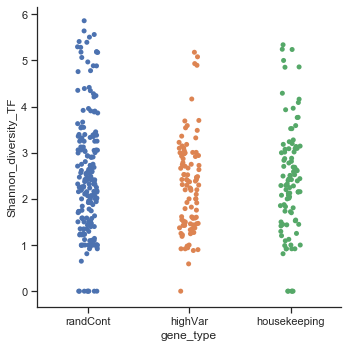

In [87]:
sns.catplot(x="gene_type", y="Shannon_diversity_TF", data=merged).savefig('../../data/plots/TF_diversity/responsive_TF_diversity.pdf', format='pdf')

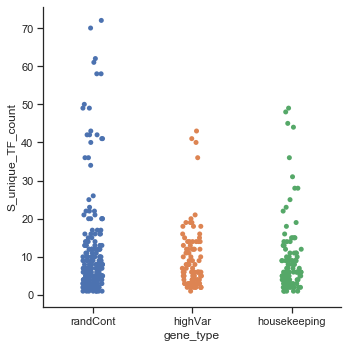

In [88]:
sns.catplot(x="gene_type", y="S_unique_TF_count", data=merged).savefig('../../data/plots/TF_diversity/responsive_no_of_unique_TFs.pdf', format='pdf')

### looks to be no different between promoter types!

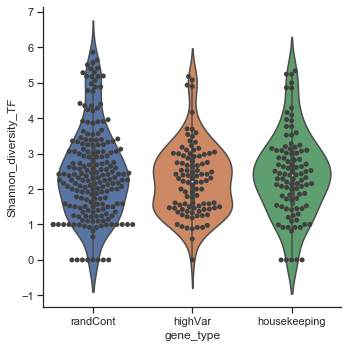

In [89]:
plot = sns.catplot(x="gene_type", y="Shannon_diversity_TF", data=merged, kind='violin')
#plot points
ax = sns.swarmplot(x="gene_type", y="Shannon_diversity_TF", data=merged, color=".25").get_figure().savefig('../../data/plots/TF_diversity/responsive_TF_shannondiversity_violin.pdf', format='pdf')

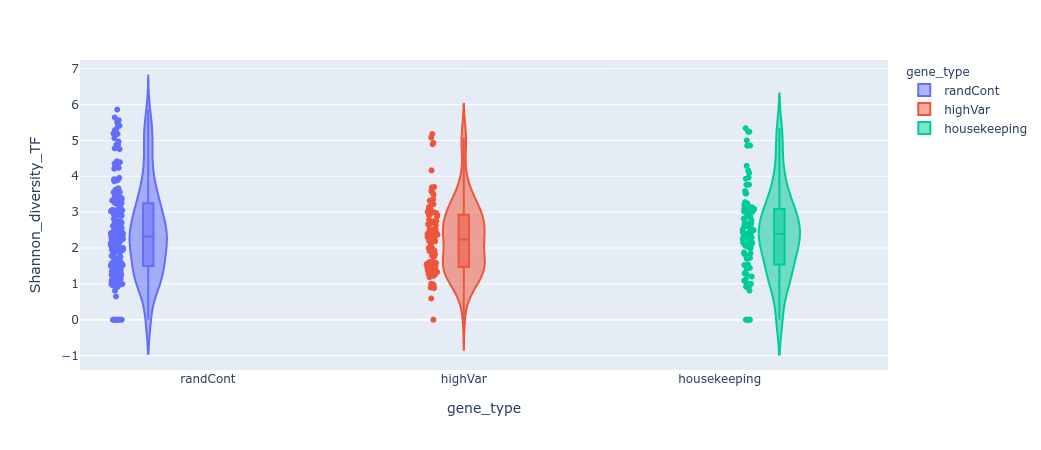

In [97]:

fig = px.violin(merged, x="gene_type", y="Shannon_diversity_TF", box=True, color="gene_type", # draw box plot inside the violin
                points='all', # can be 'outliers', or False
               )
fig.write_html('../../data/plots/TF_diversity/diversity.html', auto_open=False)
fig.show()

#### get names of each promoter type for later

In [98]:
pd.Categorical(merged.gene_type)
names = merged.gene_type.unique()
for name in names:
    print(name)

randCont
highVar
housekeeping


### test normaliity

In [99]:
#returns test statistic, p-value
for name in names:
    print('{}: {}'.format(name, stats.shapiro(merged.Shannon_diversity_TF[merged.gene_type == name])))

randCont: (0.963759183883667, 4.713857561000623e-05)
highVar: (0.9589629769325256, 0.0036050041671842337)
housekeeping: (0.9770366549491882, 0.08375871926546097)


### reject normality

### make separate dfs based on gene_type

In [100]:
constitutive = merged[merged.gene_type == 'housekeeping']
#reset indexes so residuals can be calculated later
constitutive.reset_index(inplace=True)

responsive = merged[merged.gene_type == 'highVar']
responsive.reset_index(inplace=True)

control = merged[merged.gene_type == 'randCont']
control.reset_index(inplace=True)

### q-plot - constitutive

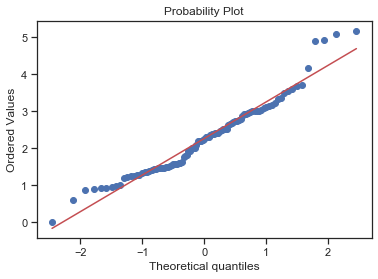

In [101]:
stats.probplot(constitutive.Shannon_diversity_TF, plot= plt);

### q-plots - responsive

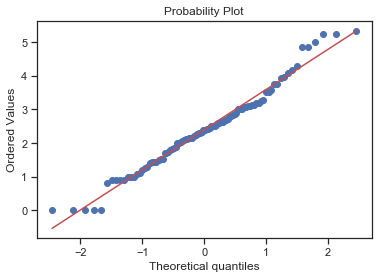

In [102]:
stats.probplot(responsive.Shannon_diversity_TF, plot= plt);

### q-plots - random control

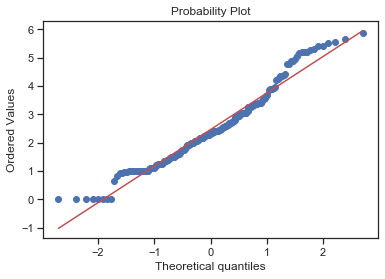

In [103]:
stats.probplot(control.Shannon_diversity_TF, plot= plt);

## test homoscedasticity (Homogeneity of Variance)

In [104]:
stats.levene(merged.Shannon_diversity_TF[merged.gene_type == names[0]], 
               merged.Shannon_diversity_TF[merged.gene_type == names[1]], 
               merged.Shannon_diversity_TF[merged.gene_type == names[2]])

LeveneResult(statistic=2.721365744170788, pvalue=0.06701533788772812)

#### fail to reject null hypothesis that variances are equal

# Kruskal-Wallis one way analysis of variance: scipy.stats.kruskal

In [105]:
stats.kruskal(merged.Shannon_diversity_TF[merged.gene_type == names[0]], 
               merged.Shannon_diversity_TF[merged.gene_type == names[1]], 
               merged.Shannon_diversity_TF[merged.gene_type == names[2]])

KruskalResult(statistic=1.1958303966297146, pvalue=0.5499569930239621)

In [106]:
#variable vs housekeeping
stats.mannwhitneyu(merged.Shannon_diversity_TF[merged.gene_type == names[1]], 
               merged.Shannon_diversity_TF[merged.gene_type == names[2]])

MannwhitneyuResult(statistic=4472.5, pvalue=0.17238318559642085)

### not significantly different

## TF_family shannon diversity

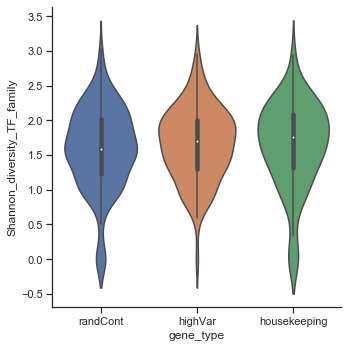

In [107]:
plot = sns.catplot(x="gene_type", y="Shannon_diversity_TF_family", data=merged, kind='violin')
#plot points
#ax = sns.swarmplot(x="gene_type", y="Shannon_diversity_TF_family", data=merged, color=".25").get_figure().savefig('../../data/plots/TF_diversity/responsive_TF_shannondiversity_family_violin.pdf', format='pdf')

In [108]:
fig = px.violin(merged, x="gene_type", y="Shannon_diversity_TF_family", box=True, # draw box plot inside the violin
                points='all', # can be 'outliers', or False
               )


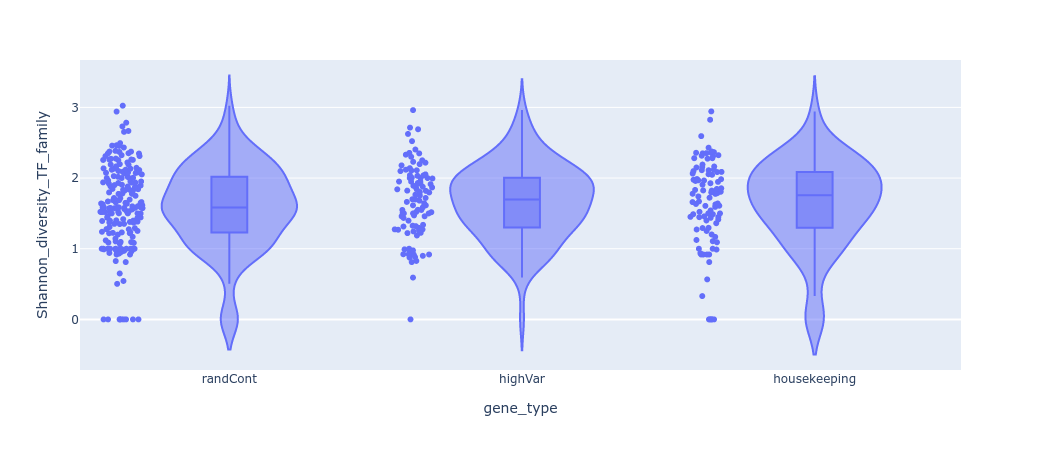

In [109]:
fig.show()

In [110]:
#test normality
#returns test statistic, p-value
for name in names:
    print('{}: {}'.format(name, stats.shapiro(merged.Shannon_diversity_TF_family[merged.gene_type == name])))

randCont: (0.9666456580162048, 0.0001020822164718993)
highVar: (0.9888584613800049, 0.5807167291641235)
housekeeping: (0.9447304606437683, 0.00043969234684482217)


In [111]:
#not normal

In [112]:
#test variance
stats.levene(merged.Shannon_diversity_TF_family[merged.gene_type == names[1]], 
               merged.Shannon_diversity_TF_family[merged.gene_type == names[2]])

LeveneResult(statistic=1.4043741966997705, pvalue=0.23743478432660753)

In [113]:
#mann whitney
#variable vs housekeeping
stats.mannwhitneyu(merged.Shannon_diversity_TF_family[merged.gene_type == names[1]], 
               merged.Shannon_diversity_TF_family[merged.gene_type == names[2]])

MannwhitneyuResult(statistic=4733.5, pvalue=0.38497616757211106)

## Analyse unique TFBS counts within promoters

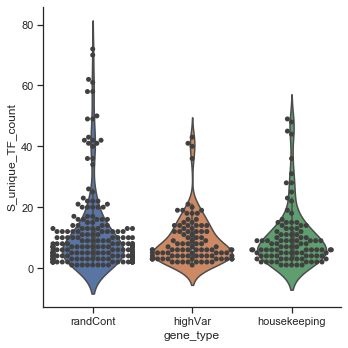

In [114]:
plot = sns.catplot(x="gene_type", y="S_unique_TF_count", data=merged, kind='violin')
#plot points
ax = sns.swarmplot(x="gene_type", y="S_unique_TF_count", data=merged, color=".25").get_figure().savefig('../../data/plots/TF_diversity/responsive_TF_unique_count.pdf', format='pdf')

In [115]:
#normality test
#returns test statistic, p-value
for name in names:
    print('{}: {}'.format(name, stats.shapiro(merged.S_unique_TF_count[merged.gene_type == name])))

randCont: (0.6819181442260742, 2.666510537865421e-19)
highVar: (0.7530405521392822, 1.3124110305462455e-11)
housekeeping: (0.7344346046447754, 5.062736688210556e-12)


test homoscedasticity (Homogeneity of Variance)

In [116]:
stats.levene(merged.S_unique_TF_count[merged.gene_type == names[0]], 
               merged.S_unique_TF_count[merged.gene_type == names[1]], 
               merged.S_unique_TF_count[merged.gene_type == names[2]])

LeveneResult(statistic=2.2622211227667703, pvalue=0.10546297048499476)

In [117]:
#fail to reject null hypothesis that variances are equal

In [118]:
#mann-whitney test

In [119]:
#variable vs housekeeping
stats.mannwhitneyu(merged.S_unique_TF_count[merged.gene_type == names[1]], 
               merged.S_unique_TF_count[merged.gene_type == names[2]])

MannwhitneyuResult(statistic=4679.5, pvalue=0.3341201165026155)

## Analyse raw TFBS counts within promoters

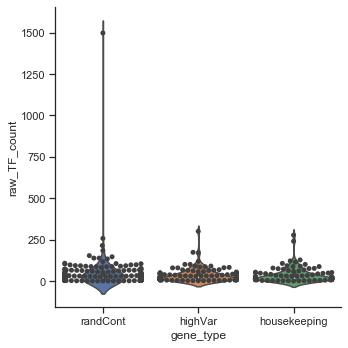

In [120]:
plot = sns.catplot(x="gene_type", y="raw_TF_count", data=merged, kind='violin')
#plot points
ax = sns.swarmplot(x="gene_type", y="raw_TF_count", data=merged, color=".25").get_figure().savefig('../../data/plots/TF_diversity/responsive_TF_raw_count.pdf', format='pdf')

In [121]:
#variable vs housekeeping
stats.mannwhitneyu(merged.raw_TF_count[merged.gene_type == names[1]], 
               merged.raw_TF_count[merged.gene_type == names[2]])

MannwhitneyuResult(statistic=4660.0, pvalue=0.3169447209456133)

## start with kmeans clustering of groupby_promoter_counts_family


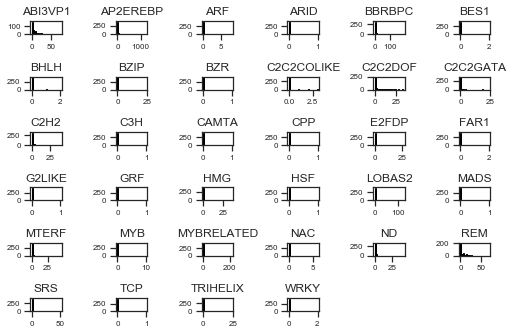

In [122]:
#Visualizing data in One Dimension 
groupby_promoter_counts_family.hist(bins=30, color='steelblue', edgecolor='black', linewidth=1.0, xlabelsize=8, ylabelsize=8, grid=False)
plt.tight_layout(rect=(0,0,1.2,1.2))

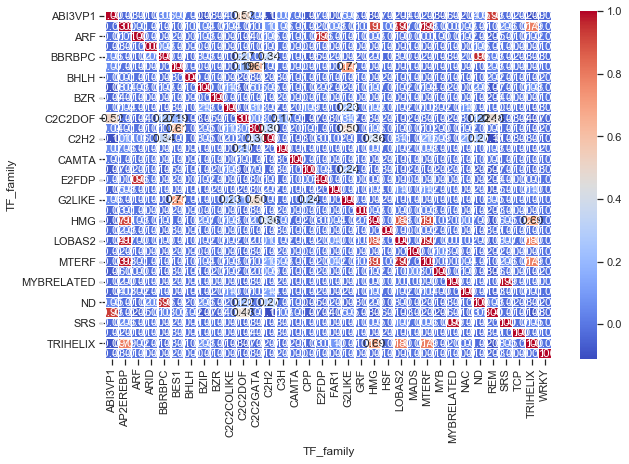

In [123]:
#Visualizing data in Two Dimensions - heatmap
#this shows correlations between different TF_family attributes
f, ax = plt.subplots(figsize=(10,6))
corr = groupby_promoter_counts_family.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap='coolwarm', fmt='.2f',
                linewidth=0.5)
f.subplots_adjust(top=0.93)

In [124]:
columns_TF_family = groupby_promoter_counts_family.columns
columns_TF_family

Index(['ABI3VP1', 'AP2EREBP', 'ARF', 'ARID', 'BBRBPC', 'BES1', 'BHLH', 'BZIP',
       'BZR', 'C2C2COLIKE', 'C2C2DOF', 'C2C2GATA', 'C2H2', 'C3H', 'CAMTA',
       'CPP', 'E2FDP', 'FAR1', 'G2LIKE', 'GRF', 'HMG', 'HSF', 'LOBAS2', 'MADS',
       'MTERF', 'MYB', 'MYBRELATED', 'NAC', 'ND', 'REM', 'SRS', 'TCP',
       'TRIHELIX', 'WRKY'],
      dtype='object', name='TF_family')

In [125]:
#Cluster using all TF columns by kmeans
kmeans = KMeans(n_clusters=8, random_state=0)
y_kmeans = kmeans.fit_predict(groupby_promoter_counts_family[['ABI3VP1', 'AP2EREBP', 'ARF', 'ARID', 'BBRBPC', 'BES1', 'BHLH', 'BZIP',
        'BZR', 'C2C2COLIKE', 'C2C2DOF', 'C2C2GATA', 'C2H2', 'C3H', 'CAMTA',
        'CPP', 'E2FDP', 'FAR1', 'G2LIKE', 'GRF', 'HMG', 'HSF', 'LOBAS2', 'MADS',
        'MTERF', 'MYB', 'MYBRELATED', 'NAC', 'ND', 'REM', 'SRS', 'TCP',
        'TRIHELIX', 'WRKY']])
groupby_promoter_counts_family['cluster']= y_kmeans

#kmeans = KMeans(n_clusters=8, random_state=0).fit(groupby_promoter_counts_family)
#y_kmeans = kmeans.predict(groupby_promoter_counts_family)

In [126]:
groupby_promoter_counts_family.cluster

promoter_AGI
AT1G01050    0
AT1G01780    5
AT1G01910    0
AT1G02000    0
AT1G03070    2
            ..
AT5G65360    0
AT5G65470    0
AT5G66250    0
AT5G67210    0
AT5G67590    0
Name: cluster, Length: 399, dtype: int32

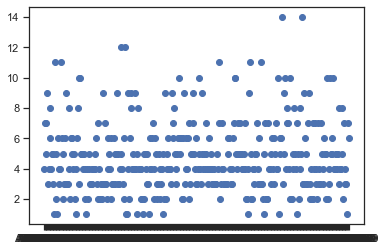

In [127]:
#Plot promoter by TF family number
plt.scatter(merged.promoter_AGI, merged.TF_family_count,);

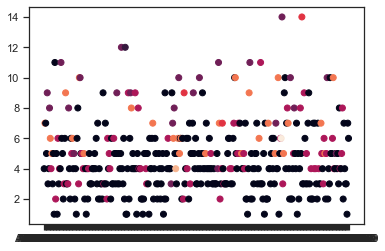

In [128]:
#same plot coloured by kmeans clusters
plt.scatter(merged.promoter_AGI, merged.TF_family_count, c=y_kmeans)
##find centre of each cluster
#centres = kmeans.cluster_centers_
##add centres to the plot
#plt.scatter(centres[:, 0], centres[:, 33], c='black', s=200, alpha=0.5)

In [129]:
#that looks really weird. I will try clustering on the geometric mean


# I need to calculate the geometric mean of TF families binding for each promoter - this normalises them as the variance of the number of predicted binding sites within each family is very skewed, with some families having 75 binding sites, and others only having 1 or 2


In [130]:
#couldn't perform geometric means as some values were 0

### run PCA

In [131]:
#add gene type column
groupby_promoter_counts_family = pd.merge(groupby_promoter_counts_family, merged[['promoter_AGI','gene_type']], on='promoter_AGI')

In [132]:
groupby_promoter_counts_family

,promoter_AGI,ABI3VP1,AP2EREBP,ARF,ARID,BBRBPC,BES1,BHLH,BZIP,BZR,...,MYBRELATED,NAC,ND,REM,SRS,TCP,TRIHELIX,WRKY,cluster,gene_type
0,AT1G01050,3,0,0,0,2,0,0,0,0,...,0,0,1,1,0,0,0,0,0,randCont
1,AT1G01780,3,1,0,0,75,0,0,0,0,...,0,0,15,4,0,0,0,0,5,highVar
2,AT1G01910,1,8,0,0,0,0,0,0,0,...,0,0,0,0,0,0,8,0,0,housekeeping
3,AT1G02000,0,4,0,0,0,0,0,0,0,...,0,1,1,1,0,0,0,0,0,highVar
4,AT1G03070,13,49,0,0,4,0,0,0,0,...,0,0,0,9,0,0,0,0,2,highVar
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,AT5G65360,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,randCont
395,AT5G65470,1,0,0,0,0,0,0,0,0,...,0,0,0,4,0,1,0,0,0,randCont
396,AT5G66250,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,randCont
397,AT5G67210,5,0,0,0,3,0,0,0,0,...,0,0,2,3,0,0,0,0,0,highVar


In [133]:
#remove random gene_type
groupby_promoter_counts_family2 = groupby_promoter_counts_family[~(groupby_promoter_counts_family.gene_type == 'randCont')].copy()
groupby_promoter_counts_family2 = groupby_promoter_counts_family2.reset_index(drop=True)
groupby_promoter_counts_family2


,promoter_AGI,ABI3VP1,AP2EREBP,ARF,ARID,BBRBPC,BES1,BHLH,BZIP,BZR,...,MYBRELATED,NAC,ND,REM,SRS,TCP,TRIHELIX,WRKY,cluster,gene_type
0,AT1G01780,3,1,0,0,75,0,0,0,0,...,0,0,15,4,0,0,0,0,5,highVar
1,AT1G01910,1,8,0,0,0,0,0,0,0,...,0,0,0,0,0,0,8,0,0,housekeeping
2,AT1G02000,0,4,0,0,0,0,0,0,0,...,0,1,1,1,0,0,0,0,0,highVar
3,AT1G03070,13,49,0,0,4,0,0,0,0,...,0,0,0,9,0,0,0,0,2,highVar
4,AT1G03457,17,0,0,0,1,0,0,0,0,...,0,0,0,8,0,0,0,0,0,highVar
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,AT5G56750,6,0,0,0,0,0,0,0,0,...,0,0,1,5,0,0,0,0,0,highVar
193,AT5G60490,17,0,0,0,2,0,0,0,0,...,0,1,0,16,0,0,0,0,3,highVar
194,AT5G61360,18,1,0,0,4,0,0,0,0,...,1,0,0,13,0,0,0,0,3,highVar
195,AT5G64813,0,0,0,0,8,0,0,0,0,...,0,0,4,0,0,0,0,0,0,housekeeping


In [134]:
#standardise the data - have to scale features before applying a PCA. Standardise to mean = 0, variance = 1
TF_Families = ['ABI3VP1', 'AP2EREBP', 'ARF', 'ARID', 'BBRBPC', 'BES1', 'BHLH', 'BZIP',
        'BZR', 'C2C2COLIKE', 'C2C2DOF', 'C2C2GATA', 'C2H2', 'C3H', 'CAMTA',
        'CPP', 'E2FDP', 'FAR1', 'G2LIKE', 'GRF', 'HMG', 'HSF', 'LOBAS2', 'MADS',
        'MTERF', 'MYB', 'MYBRELATED', 'NAC', 'ND', 'REM', 'SRS', 'TCP',
        'TRIHELIX', 'WRKY']
#separate out the families
x = groupby_promoter_counts_family2.loc[:, TF_Families].values
#separate out the gene_type
y = groupby_promoter_counts_family2.loc[:,['gene_type']].values
#standardise the families
x = StandardScaler().fit_transform(x)

In [135]:
#ignore this cell, was trying to calculate the geometric means earlier and I moved it down to here from above
# variable_family_geometric_means = stats.mstats.gmean(groupby_promoter_counts_family[TF_Families], axis=0)
# variable_family_geometric_means
#this didnt work

In [136]:
#this is what the transform looks like
test = pd.DataFrame(x)
test.columns = TF_Families
test

,ABI3VP1,AP2EREBP,ARF,ARID,BBRBPC,BES1,BHLH,BZIP,BZR,C2C2COLIKE,...,MTERF,MYB,MYBRELATED,NAC,ND,REM,SRS,TCP,TRIHELIX,WRKY
0,-0.542558,-0.210440,-0.088038,-0.071429,3.755188,-0.071429,0.0,-0.102215,0.0,-0.197701,...,-0.210981,-0.128390,-0.097286,-0.170350,3.654031,-0.343924,-0.093398,0.0,-0.221920,0.0
1,-0.734795,0.161607,-0.088038,-0.071429,-0.388729,-0.071429,0.0,-0.102215,0.0,-0.197701,...,0.882789,-0.128390,-0.097286,-0.170350,-0.354010,-0.827875,-0.093398,0.0,7.550213,0.0
2,-0.830914,-0.050991,-0.088038,-0.071429,-0.388729,-0.071429,0.0,-0.102215,0.0,-0.197701,...,-0.210981,-0.128390,-0.097286,3.185547,-0.086807,-0.706887,-0.093398,0.0,-0.221920,0.0
3,0.418628,2.340737,-0.088038,-0.071429,-0.167720,-0.071429,0.0,-0.102215,0.0,-0.197701,...,0.882789,-0.128390,-0.097286,-0.170350,-0.354010,0.261014,-0.093398,0.0,-0.221920,0.0
4,0.803103,-0.263589,-0.088038,-0.071429,-0.333477,-0.071429,0.0,-0.102215,0.0,-0.197701,...,-0.210981,-0.128390,-0.097286,-0.170350,-0.354010,0.140026,-0.093398,0.0,-0.221920,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,-0.254202,-0.263589,-0.088038,-0.071429,-0.388729,-0.071429,0.0,-0.102215,0.0,-0.197701,...,-0.210981,-0.128390,-0.097286,-0.170350,-0.086807,-0.222937,-0.093398,0.0,-0.221920,0.0
193,0.803103,-0.263589,-0.088038,-0.071429,-0.278224,-0.071429,0.0,-0.102215,0.0,-0.197701,...,-0.210981,-0.128390,-0.097286,3.185547,-0.354010,1.107927,-0.093398,0.0,-0.221920,0.0
194,0.899222,-0.210440,-0.088038,-0.071429,-0.167720,-0.071429,0.0,-0.102215,0.0,-0.197701,...,-0.210981,-0.128390,-0.032538,-0.170350,-0.354010,0.744964,-0.093398,0.0,-0.221920,0.0
195,-0.830914,-0.263589,-0.088038,-0.071429,0.053289,-0.071429,0.0,-0.102215,0.0,-0.197701,...,-0.210981,-0.128390,-0.097286,-0.170350,0.714801,-0.827875,-0.093398,0.0,-0.221920,0.0


In [137]:
#run PCA, letting the algorithm decide on number of components such that 95% of the variation is maintained
#make instance of the model
pca = PCA(.95)
#fit PCA to the data
principalComponents = pca.fit_transform(x)
#make intoi dataframe
principalDf = pd.DataFrame(data= principalComponents)

In [138]:
principalDf

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,-0.456839,2.730778,-3.931427,-0.373502,1.842328,-1.489228,-0.538726,-0.845647,0.535415,0.172377,-0.081007,0.079180,0.046107,0.846636,-1.173948,0.898128,0.360329,-0.504610,-1.450746
1,3.902231,-1.007276,0.715871,-0.012663,-0.344777,-0.124063,-1.243952,-1.799502,1.064682,-1.246539,0.113496,0.077355,0.189235,-0.688540,-2.430926,1.232490,-0.024593,5.360933,1.060202
2,-0.240511,-0.909398,0.435677,-0.131940,-0.094893,-0.725982,1.942145,-0.948339,0.250189,-0.077276,-0.059884,0.060936,0.085370,0.177798,-0.394694,-0.030308,-2.300840,-0.389582,-0.416659
3,3.766953,1.225778,-0.558064,0.158017,-0.401885,0.834376,0.135703,1.909155,-1.350372,0.113018,0.280660,-0.263900,-0.069894,-0.672785,0.435662,-0.971413,-0.361120,1.034268,-2.211640
4,-0.706475,-0.226023,0.167056,0.083173,-0.587167,0.521380,-0.183281,0.031470,-0.091807,-0.036336,0.014331,-0.010449,-0.159008,-0.186146,-0.027926,-0.082689,0.006920,-0.158623,0.288163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,-0.474320,-0.647656,0.299710,-0.041774,-0.215769,-0.179595,-0.239859,-0.129333,-0.025175,-0.019892,0.028095,-0.009599,-0.049832,-0.199921,-0.190497,-0.009656,0.004376,-0.339684,0.084770
193,-1.054951,0.742396,-0.274555,0.234787,-1.056178,1.198879,1.972755,-0.611310,0.203319,-0.042811,-0.095662,0.064028,-0.174125,0.339736,-0.089332,0.035030,-2.260349,0.229452,-1.124703
194,1.450721,0.494526,-0.185955,0.414011,-1.153529,2.014441,-0.462856,-1.064884,0.981680,-0.295538,-0.261707,0.203830,-0.371069,0.745562,0.543141,0.618632,0.515758,-3.190465,1.136344
195,0.176531,-0.474578,-0.264764,-0.243109,0.560942,-1.161156,-0.225730,0.141513,-0.257868,-0.042396,0.094602,-0.063474,0.067794,-0.272908,-0.373767,-0.124890,-0.037624,-0.315009,-0.005644


In [139]:
finalDF_variable_promoters = pd.concat([principalDf, groupby_promoter_counts_family2[['promoter_AGI', 'gene_type']]], axis=1)
#finalDF_variable_promoters = finalDF_variable_promoters.set_index('promoter_AGI')
finalDF_variable_promoters

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,promoter_AGI,gene_type
0,-0.456839,2.730778,-3.931427,-0.373502,1.842328,-1.489228,-0.538726,-0.845647,0.535415,0.172377,...,0.079180,0.046107,0.846636,-1.173948,0.898128,0.360329,-0.504610,-1.450746,AT1G01780,highVar
1,3.902231,-1.007276,0.715871,-0.012663,-0.344777,-0.124063,-1.243952,-1.799502,1.064682,-1.246539,...,0.077355,0.189235,-0.688540,-2.430926,1.232490,-0.024593,5.360933,1.060202,AT1G01910,housekeeping
2,-0.240511,-0.909398,0.435677,-0.131940,-0.094893,-0.725982,1.942145,-0.948339,0.250189,-0.077276,...,0.060936,0.085370,0.177798,-0.394694,-0.030308,-2.300840,-0.389582,-0.416659,AT1G02000,highVar
3,3.766953,1.225778,-0.558064,0.158017,-0.401885,0.834376,0.135703,1.909155,-1.350372,0.113018,...,-0.263900,-0.069894,-0.672785,0.435662,-0.971413,-0.361120,1.034268,-2.211640,AT1G03070,highVar
4,-0.706475,-0.226023,0.167056,0.083173,-0.587167,0.521380,-0.183281,0.031470,-0.091807,-0.036336,...,-0.010449,-0.159008,-0.186146,-0.027926,-0.082689,0.006920,-0.158623,0.288163,AT1G03457,highVar
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,-0.474320,-0.647656,0.299710,-0.041774,-0.215769,-0.179595,-0.239859,-0.129333,-0.025175,-0.019892,...,-0.009599,-0.049832,-0.199921,-0.190497,-0.009656,0.004376,-0.339684,0.084770,AT5G56750,highVar
193,-1.054951,0.742396,-0.274555,0.234787,-1.056178,1.198879,1.972755,-0.611310,0.203319,-0.042811,...,0.064028,-0.174125,0.339736,-0.089332,0.035030,-2.260349,0.229452,-1.124703,AT5G60490,highVar
194,1.450721,0.494526,-0.185955,0.414011,-1.153529,2.014441,-0.462856,-1.064884,0.981680,-0.295538,...,0.203830,-0.371069,0.745562,0.543141,0.618632,0.515758,-3.190465,1.136344,AT5G61360,highVar
195,0.176531,-0.474578,-0.264764,-0.243109,0.560942,-1.161156,-0.225730,0.141513,-0.257868,-0.042396,...,-0.063474,0.067794,-0.272908,-0.373767,-0.124890,-0.037624,-0.315009,-0.005644,AT5G64813,housekeeping


In [140]:
pca_variance = pca.explained_variance_ratio_
pca_variance[0]

0.1432938234072527

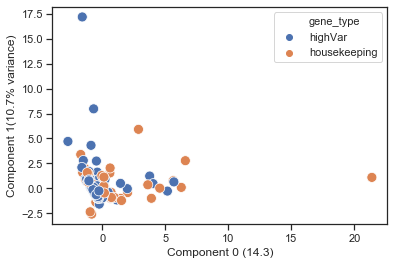

In [141]:
#plot first 2 clusters
plot = sns.scatterplot(x=0, y=1, hue='gene_type', data=finalDF_variable_promoters, s=100)
#plt.xlabel('hi')

plt.xlabel(f'Component 0 ({(pca_variance[0]*100).round(1)})')
plt.ylabel(f'Component 1({(pca_variance[1]*100).round(1)}% variance)');

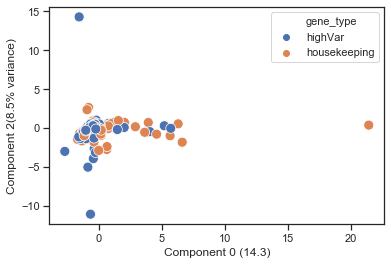

In [142]:
#plot 1st and 3rd clusters
plot = sns.scatterplot(x=0, y=2, hue='gene_type', data=finalDF_variable_promoters,s=100)
plt.xlabel(f'Component 0 ({(pca_variance[0]*100).round(1)})')
plt.ylabel(f'Component 2({(pca_variance[2]*100).round(1)}% variance)');

### try hierarchical clustering

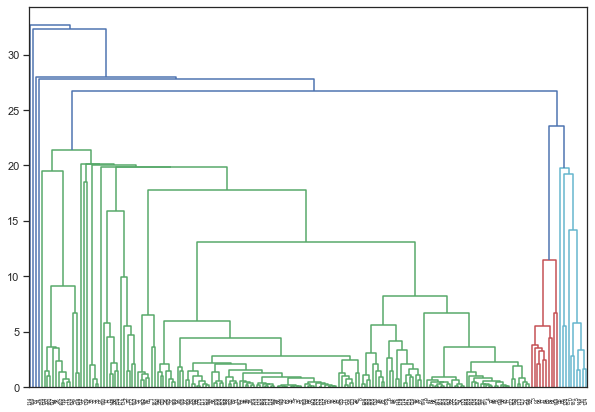

In [143]:

#separate out the families
x2 = finalDF_variable_promoters.drop(['promoter_AGI','gene_type'],axis=1)
#separate out the gene_type
y2 = finalDF_variable_promoters.loc[:,['gene_type']].values
#plot dendrograms to work out how many clusters to use
plt.figure(figsize=(10, 7))
dend = shc.dendrogram(shc.linkage(x2, method='ward'))
#linkage matrix
z = shc.linkage(x2, method='ward')

#cluster.fit_predict(x)


##### In the script above we import the hierarchy class of the scipy.cluster library as shc. The hierarchy class has a dendrogram method which takes the value returned by the linkage method of the same class. The linkage method takes the dataset and the method to minimize distances as parameters. We use 'ward' as the method since it minimizes then variants of distances between the clusters.

##### In the code above we import the AgglomerativeClustering class from the "sklearn.cluster" library. The number of parameters is set to 2 using the n_clusters parameter while the affinity is set to "euclidean" (distance between the datapoints). Finally linkage parameter is set to "ward", which minimizes the variant between the clusters.
##### Next we call the fit_predict method from the AgglomerativeClustering class variable cluster. This method returns the names of the clusters that each data point belongs to.

In [144]:
#determine optimal number of clusters using inconsistant method
from scipy.cluster.hierarchy import inconsistent
depth = 5
incons = inconsistent(z, depth)
incons[-10:]

#bit useless

array([[10.97640815,  7.75155892, 12.        ,  1.16554143],
       [13.51196799,  8.72706085, 10.        ,  0.76168635],
       [15.16911521,  8.53058205,  8.        ,  0.58544764],
       [11.94314475,  8.56280413, 14.        ,  1.10299579],
       [10.2763214 ,  7.16555423, 12.        ,  1.85188478],
       [13.99708472,  7.67180237, 20.        ,  1.66252214],
       [17.76896375,  7.28027044, 13.        ,  1.3714694 ],
       [22.031685  ,  5.24455335,  9.        ,  1.13488837],
       [26.62214535,  3.80425011,  6.        ,  1.49512184],
       [29.49932394,  2.7849596 ,  5.        ,  1.14845741]])

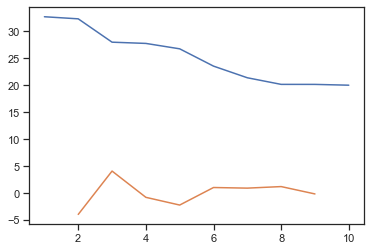

clusters: 3


In [145]:
#try elbow method
last = z[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print("clusters:", k)


In [146]:
#3 clusters

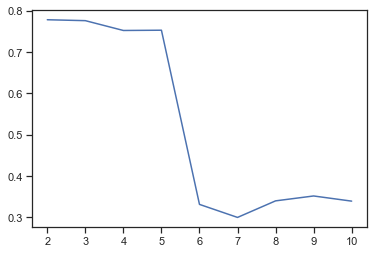

In [147]:
#silhouette method - The silhouette value measures how similar a point is to its own cluster (cohesion) compared to other clusters (separation).
from sklearn.metrics import silhouette_score
sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(x2)
    labels = kmeans.labels_
    sil.append(silhouette_score(x2, labels, metric = 'euclidean'))
#plot silhouette_score vs k
plot = sns.lineplot(x=list(range(2, 11,1)), y=sil)

In [148]:
#could do 5 cluster

In [149]:
#plot
#plt.scatter(x2[0],x2[1], c=cluster.labels_, cmap='rainbow')

In [150]:
#cluster again using kmeans
#Cluster using all TF columns by kmeans, with k of 5
kmeans = KMeans(n_clusters=5, random_state=0)
y_kmeans = kmeans.fit_predict(x2)
x2['cluster']= y_kmeans

#kmeans = KMeans(n_clusters=8, random_state=0).fit(groupby_promoter_counts_family)
#y_kmeans = kmeans.predict(groupby_promoter_counts_family)

In [151]:
x2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,cluster
0,-0.456839,2.730778,-3.931427,-0.373502,1.842328,-1.489228,-0.538726,-0.845647,0.535415,0.172377,-0.081007,0.079180,0.046107,0.846636,-1.173948,0.898128,0.360329,-0.504610,-1.450746,2
1,3.902231,-1.007276,0.715871,-0.012663,-0.344777,-0.124063,-1.243952,-1.799502,1.064682,-1.246539,0.113496,0.077355,0.189235,-0.688540,-2.430926,1.232490,-0.024593,5.360933,1.060202,0
2,-0.240511,-0.909398,0.435677,-0.131940,-0.094893,-0.725982,1.942145,-0.948339,0.250189,-0.077276,-0.059884,0.060936,0.085370,0.177798,-0.394694,-0.030308,-2.300840,-0.389582,-0.416659,0
3,3.766953,1.225778,-0.558064,0.158017,-0.401885,0.834376,0.135703,1.909155,-1.350372,0.113018,0.280660,-0.263900,-0.069894,-0.672785,0.435662,-0.971413,-0.361120,1.034268,-2.211640,0
4,-0.706475,-0.226023,0.167056,0.083173,-0.587167,0.521380,-0.183281,0.031470,-0.091807,-0.036336,0.014331,-0.010449,-0.159008,-0.186146,-0.027926,-0.082689,0.006920,-0.158623,0.288163,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,-0.474320,-0.647656,0.299710,-0.041774,-0.215769,-0.179595,-0.239859,-0.129333,-0.025175,-0.019892,0.028095,-0.009599,-0.049832,-0.199921,-0.190497,-0.009656,0.004376,-0.339684,0.084770,0
193,-1.054951,0.742396,-0.274555,0.234787,-1.056178,1.198879,1.972755,-0.611310,0.203319,-0.042811,-0.095662,0.064028,-0.174125,0.339736,-0.089332,0.035030,-2.260349,0.229452,-1.124703,2
194,1.450721,0.494526,-0.185955,0.414011,-1.153529,2.014441,-0.462856,-1.064884,0.981680,-0.295538,-0.261707,0.203830,-0.371069,0.745562,0.543141,0.618632,0.515758,-3.190465,1.136344,0
195,0.176531,-0.474578,-0.264764,-0.243109,0.560942,-1.161156,-0.225730,0.141513,-0.257868,-0.042396,0.094602,-0.063474,0.067794,-0.272908,-0.373767,-0.124890,-0.037624,-0.315009,-0.005644,0


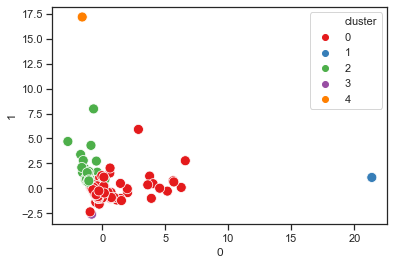

In [152]:
#plot first 2 PCA clusters
#add custom palette size as sns doesnt like having numeric values for hue palette=sns.color_palette("Set1", 6)
plot = sns.scatterplot(x=0, y=1, hue='cluster', data=x2, palette=sns.color_palette("Set1", 5),s=100)

In [153]:
#make new df using the kmeans clustering
finalDF_variable_promoters2 = pd.concat([finalDF_variable_promoters, x2.cluster], axis=1)
#finalDF_variable_promoters = finalDF_variable_promoters.set_index('promoter_AGI')
#finalDF_variable_promoters2 = finalDF_variable_promoters2.set_index('promoter_AGI')
finalDF_variable_promoters2 = finalDF_variable_promoters2.rename(columns={'cluster':'PCA_KMeans_cluster'})
#change dtype of cluster column to categorical

finalDF_variable_promoters2 = finalDF_variable_promoters2.astype({'PCA_KMeans_cluster':'object'})


In [154]:
finalDF_variable_promoters2.dtypes

0                     float64
1                     float64
2                     float64
3                     float64
4                     float64
5                     float64
6                     float64
7                     float64
8                     float64
9                     float64
10                    float64
11                    float64
12                    float64
13                    float64
14                    float64
15                    float64
16                    float64
17                    float64
18                    float64
promoter_AGI           object
gene_type              object
PCA_KMeans_cluster     object
dtype: object

In [155]:
finalDF_variable_promoters2.PCA_KMeans_cluster

0      2
1      0
2      0
3      0
4      0
      ..
192    0
193    2
194    0
195    0
196    0
Name: PCA_KMeans_cluster, Length: 197, dtype: object

In [156]:
#plot gene_type vs cluster
#plot = sns.scatterplot(x='promoter_AGI', y='gene_type', hue='cluster', data=finalDF_variable_promoters2)

In [157]:
finalDF_variable_promoters2.groupby(by='gene_type', as_index=False).agg({'PCA_KMeans_cluster': pd.Series.nunique})


,gene_type,PCA_KMeans_cluster
0,highVar,3
1,housekeeping,4


In [158]:
finalDF_variable_promoters2.groupby('gene_type')['PCA_KMeans_cluster'].value_counts()

gene_type     PCA_KMeans_cluster
highVar       0                     76
              2                     22
              4                      1
housekeeping  0                     87
              2                      9
              1                      1
              3                      1
Name: PCA_KMeans_cluster, dtype: int64

## Do hierarchical clustering on raw TFBS family data (Ie. not using PCA)

In [159]:
groupby_promoter_counts_family

,promoter_AGI,ABI3VP1,AP2EREBP,ARF,ARID,BBRBPC,BES1,BHLH,BZIP,BZR,...,MYBRELATED,NAC,ND,REM,SRS,TCP,TRIHELIX,WRKY,cluster,gene_type
0,AT1G01050,3,0,0,0,2,0,0,0,0,...,0,0,1,1,0,0,0,0,0,randCont
1,AT1G01780,3,1,0,0,75,0,0,0,0,...,0,0,15,4,0,0,0,0,5,highVar
2,AT1G01910,1,8,0,0,0,0,0,0,0,...,0,0,0,0,0,0,8,0,0,housekeeping
3,AT1G02000,0,4,0,0,0,0,0,0,0,...,0,1,1,1,0,0,0,0,0,highVar
4,AT1G03070,13,49,0,0,4,0,0,0,0,...,0,0,0,9,0,0,0,0,2,highVar
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,AT5G65360,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,randCont
395,AT5G65470,1,0,0,0,0,0,0,0,0,...,0,0,0,4,0,1,0,0,0,randCont
396,AT5G66250,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,randCont
397,AT5G67210,5,0,0,0,3,0,0,0,0,...,0,0,2,3,0,0,0,0,0,highVar


#### Randomly select 100 random_control genes, so that size of all groups is 100 (or roughly 100 at least)

In [160]:
control_genetype = groupby_promoter_counts_family[groupby_promoter_counts_family.gene_type == 'randCont']
control_genetype 

,promoter_AGI,ABI3VP1,AP2EREBP,ARF,ARID,BBRBPC,BES1,BHLH,BZIP,BZR,...,MYBRELATED,NAC,ND,REM,SRS,TCP,TRIHELIX,WRKY,cluster,gene_type
0,AT1G01050,3,0,0,0,2,0,0,0,0,...,0,0,1,1,0,0,0,0,0,randCont
5,AT1G03400,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,randCont
7,AT1G03560,10,75,0,0,0,0,0,0,0,...,0,0,0,11,0,0,0,0,2,randCont
9,AT1G04250,19,0,0,0,0,0,0,0,0,...,0,0,0,18,0,0,3,0,3,randCont
11,AT1G05810,0,0,0,0,2,0,0,0,1,...,0,0,0,0,0,0,0,0,0,randCont
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,AT5G64050,0,14,0,0,4,0,0,0,0,...,0,0,1,0,0,0,0,0,0,randCont
394,AT5G65360,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,randCont
395,AT5G65470,1,0,0,0,0,0,0,0,0,...,0,0,0,4,0,1,0,0,0,randCont
396,AT5G66250,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,randCont


In [162]:
#random sample of 100, using seed 1
control_genetype_sample = control_genetype.sample(100, random_state=1)
control_genetype_sample.to_csv('../../data/genes/random_100.csv')
control_genetype_sample

,promoter_AGI,ABI3VP1,AP2EREBP,ARF,ARID,BBRBPC,BES1,BHLH,BZIP,BZR,...,MYBRELATED,NAC,ND,REM,SRS,TCP,TRIHELIX,WRKY,cluster,gene_type
391,AT5G62650,4,0,0,0,0,0,0,0,0,...,0,0,0,6,0,0,0,0,0,randCont
183,AT3G09210,1,186,0,0,5,0,0,0,0,...,1,0,1,5,0,0,0,0,4,randCont
349,AT5G20700,28,0,0,0,0,0,0,0,0,...,1,0,0,27,0,0,0,0,3,randCont
246,AT3G58460,1,0,0,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,randCont
74,AT1G59910,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,2,0,randCont
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,AT5G13410,2,23,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,randCont
379,AT5G56090,29,0,0,0,0,0,0,0,0,...,0,0,0,23,0,0,0,0,3,randCont
315,AT5G05170,1,1,1,0,5,0,0,0,0,...,1,0,0,1,0,0,0,0,0,randCont
205,AT3G18110,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,randCont


In [163]:
groupby_promoter_counts_family_filtered = groupby_promoter_counts_family.copy()
#drop randCont rows
groupby_promoter_counts_family_filtered = groupby_promoter_counts_family_filtered[~(groupby_promoter_counts_family.gene_type == 'randCont')]
groupby_promoter_counts_family_filtered

,promoter_AGI,ABI3VP1,AP2EREBP,ARF,ARID,BBRBPC,BES1,BHLH,BZIP,BZR,...,MYBRELATED,NAC,ND,REM,SRS,TCP,TRIHELIX,WRKY,cluster,gene_type
1,AT1G01780,3,1,0,0,75,0,0,0,0,...,0,0,15,4,0,0,0,0,5,highVar
2,AT1G01910,1,8,0,0,0,0,0,0,0,...,0,0,0,0,0,0,8,0,0,housekeeping
3,AT1G02000,0,4,0,0,0,0,0,0,0,...,0,1,1,1,0,0,0,0,0,highVar
4,AT1G03070,13,49,0,0,4,0,0,0,0,...,0,0,0,9,0,0,0,0,2,highVar
6,AT1G03457,17,0,0,0,1,0,0,0,0,...,0,0,0,8,0,0,0,0,0,highVar
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,AT5G56750,6,0,0,0,0,0,0,0,0,...,0,0,1,5,0,0,0,0,0,highVar
389,AT5G60490,17,0,0,0,2,0,0,0,0,...,0,1,0,16,0,0,0,0,3,highVar
390,AT5G61360,18,1,0,0,4,0,0,0,0,...,1,0,0,13,0,0,0,0,3,highVar
393,AT5G64813,0,0,0,0,8,0,0,0,0,...,0,0,4,0,0,0,0,0,0,housekeeping


In [164]:
#concat the dfs, and drop rows if present in groupby_promoter

groupby_promoter_counts_family_filtered = pd.concat([groupby_promoter_counts_family_filtered, control_genetype_sample], axis=0, join='outer', ignore_index=True, keys=None,
          levels=None, names=None, verify_integrity=False, copy=True)
groupby_promoter_counts_family_filtered

,promoter_AGI,ABI3VP1,AP2EREBP,ARF,ARID,BBRBPC,BES1,BHLH,BZIP,BZR,...,MYBRELATED,NAC,ND,REM,SRS,TCP,TRIHELIX,WRKY,cluster,gene_type
0,AT1G01780,3,1,0,0,75,0,0,0,0,...,0,0,15,4,0,0,0,0,5,highVar
1,AT1G01910,1,8,0,0,0,0,0,0,0,...,0,0,0,0,0,0,8,0,0,housekeeping
2,AT1G02000,0,4,0,0,0,0,0,0,0,...,0,1,1,1,0,0,0,0,0,highVar
3,AT1G03070,13,49,0,0,4,0,0,0,0,...,0,0,0,9,0,0,0,0,2,highVar
4,AT1G03457,17,0,0,0,1,0,0,0,0,...,0,0,0,8,0,0,0,0,0,highVar
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,AT5G13410,2,23,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,randCont
293,AT5G56090,29,0,0,0,0,0,0,0,0,...,0,0,0,23,0,0,0,0,3,randCont
294,AT5G05170,1,1,1,0,5,0,0,0,0,...,1,0,0,1,0,0,0,0,0,randCont
295,AT3G18110,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,randCont


### run hierarchical clustering on groupby_promoter_counts_family_filtered

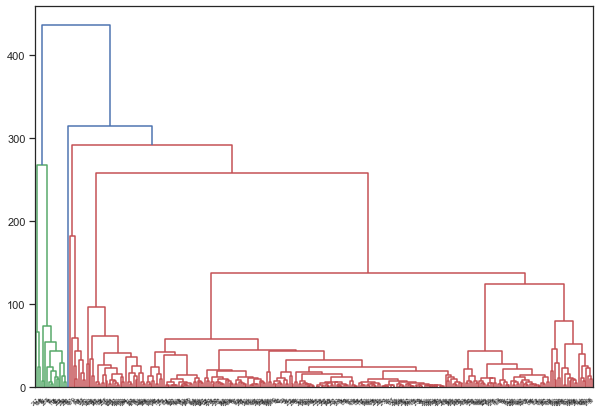

In [165]:

#separate out the families
rawx = groupby_promoter_counts_family_filtered.drop(['gene_type', 'cluster'],axis=1)
rawx = rawx.set_index('promoter_AGI')
#separate out the gene_type
rawy = groupby_promoter_counts_family_filtered.loc[:,['gene_type']].values
#plot dendrograms to work out how many clusters to use
plt.figure(figsize=(10, 7))
dend = shc.dendrogram(shc.linkage(rawx, method='ward'), leaf_rotation=45)
#linkage matrix
rawz = shc.linkage(rawx, method='ward')
ax = plt.gca()
x_labels = ax.get_xmajorticklabels()

In [166]:
# #do same again but colour by gene_type
# dflt_col = "#808080"   # Unclustered grey
# D_leaf_colors = {'Text(5, 0, \'247\')':'#B061FF'}

# # * rows in Z correspond to "inverted U" links that connect clusters
# # * rows are ordered by increasing distance
# # * if the colors of the connected clusters match, use that color for link
# link_cols = {}
# for i, i12 in enumerate(rawz[:,:2].astype(int)):
#   c1, c2 = (link_cols[x] if x > len(rawz) else D_leaf_colors["Text(%d"%x]
#     for x in i12)
#   link_cols[i+1+len(rawz)] = c1 if c1 == c2 else dflt_col

In [167]:
#try again from scratch
#see http://datanongrata.com/2019/04/27/67/

from collections import defaultdict
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from matplotlib.colors import rgb2hex, colorConverter
from scipy.cluster.hierarchy import set_link_color_palette
import pandas as pd
import scipy.cluster.hierarchy as sch

##### We define a Clusters class which gives an HTML representation of the cluster assignments, then a function to get the cluster assignments to get a clean legend that tells us which countries are in which cluster, and what the colors assigned to each cluster mean. This code is originally from http://www.nxn.se/valent/extract-cluster-elements-by-color-in-python

In [168]:
class Clusters(dict):
    def _repr_html_(self):
        html = '<table style="border: 0;">'
        for c in self:
            hx = rgb2hex(colorConverter.to_rgb(c))
            html += '<tr style="border: 0;">' \
            '<td style="background-color: {0}; ' \
                       'border: 0;">' \
            '<code style="background-color: {0};">'.format(hx)
            html += c + '</code></td>'
            html += '<td style="border: 0"><code>' 
            html += repr(self[c]) + '</code>'
            html += '</td></tr>'

        html += '</table>'

        return html
def get_cluster_classes(den, label='ivl'):
    cluster_idxs = defaultdict(list)
    for c, pi in zip(den['color_list'], den['icoord']):
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))
    
    cluster_classes = Clusters()
    for c, l in cluster_idxs.items():
        i_l = [den[label][i] for i in l]
        cluster_classes[c] = i_l
    
    return cluster_classes

##### 

I define a function to roll the transpose, distance calculation, linkage, and graphing the dendrogram into one step. Most of the lines are setting matplotlib parameters. The function accepts the number of desired clusters and a pandas dataframe as input and provides a dendrogram as output.

Four other arguments after df and numclust: transpose, which simply makes it so that we use the index of the dataframe when set to True and columns when set to False, and dataname, which accepts a string that describes the data and goes in the title of the rendered dendrogram. Data_dist and data_link use the same distance and linkage methods as given above. Save indicates whether you'd like to save the figure to a PNG. Xticksize sets the size of the x ticks, which is important for legibility.


In [169]:
def get_clust_graph(df, numclust, transpose=False, dataname=None, save=False, xticksize=8):
    if transpose==True:
        aml=df.transpose()
        xl="x-axis"
    else:
        aml=df
        xl="y-axis"
    data_dist = pdist(aml.transpose()) # computing the distance
    data_link = linkage(data_dist,  metric='correlation', method='complete')#method="complete") # computing the linkage
    B=dendrogram(data_link,labels=list(aml.columns),p=numclust, truncate_mode="lastp",get_leaves=True, count_sort='ascending', show_contracted=True)
    #myInd = [i for i, c in zip(B['ivl'], B['color_list']) if c=='g']
    get_cluster_classes(B)
    ax=plt.gca()
    ax.tick_params(axis='x', which='major', labelsize=xticksize)
    ax.tick_params(axis='y', which='major', labelsize=15)
    plt.xlabel(xl)
    #plt.set_size_inches(18.5, 10.5)
    plt.ylabel('Distance')
    plt.suptitle(xl+" clustering for "+dataname, fontweight='bold', fontsize=16);
    if save:
        plt.savefig(str(df.index.name)+str(numclust)+"tr_"+str(transpose)+"dn_"+str(dataname)+save+'.png')
    else:
        print("Not saving")
    return get_cluster_classes(B)

In [170]:
##### The following is a helper function to show cluster members when the number of clusters is less than the total number of rows.


In [171]:
def give_cluster_assigns(df, numclust, transpose=True):
    if transpose==True:
        data_dist = pdist(df.transpose())
        data_link = linkage(data_dist,  metric='correlation', method='complete')
        cluster_assigns=pd.Series(sch.fcluster(data_link, numclust, criterion='maxclust', monocrit=None), index=df.columns)
    else:
        data_dist = pdist(df)
        data_link = linkage(data_dist,  metric='correlation', method='complete')
        cluster_assigns=pd.Series(sch.fcluster(data_link, numclust, criterion='maxclust', monocrit=None), index=df.index)

    for i in np.arange(1,numclust+1):
       print("Cluster ",str(i),": ( N =",len(cluster_assigns[cluster_assigns==i].index),")", ", ".join(list(cluster_assigns[cluster_assigns==i].index)))


##### Let's try doing this with all the genes available from the dataset.

In [172]:
rawx.shape

(297, 34)

Not saving


g,"['AT3G50430', 'AT3G09210', 'AT5G15770']"
r,"['AT1G16290', 'AT3G01340', 'AT2G20130', 'AT2G47390', 'AT4G36020', 'AT1G27440', 'AT3G17630', 'AT2G46180', 'AT3G44240', 'AT1G11650', 'AT1G08780', 'AT1G03070', 'AT3G12260', 'AT5G47400', 'AT4G07960', 'AT1G28960', 'AT1G10430', 'AT4G30900', 'AT1G01780', 'AT1G03920', 'AT3G20230', 'AT3G60310', 'AT3G01980', 'AT5G45840', 'AT2G22040', 'AT4G01575', 'AT5G46750', 'AT3G61460', 'AT5G15600', 'AT1G34550', 'AT5G45940', 'AT1G08340', 'AT3G60570', 'AT3G25160', 'AT1G64400', 'AT1G11170', 'AT2G27600', 'AT5G17420', 'AT3G59280', 'AT3G51610', 'AT5G24090', 'AT2G31370', 'AT5G20700', 'AT5G11670', 'AT5G06600', 'AT3G03790', 'AT1G68410', 'AT3G10960', 'AT3G46600', 'AT1G10070', 'AT5G56090', 'AT1G08600', 'AT3G61160', 'AT5G16540', 'AT1G74700', 'AT3G10380', 'AT5G07950', 'AT4G26410', 'AT3G57890', 'AT4G33650', 'AT1G04700', 'AT3G01270', 'AT3G45750', 'AT3G09760', 'AT3G19870', 'AT1G29040', 'AT4G34670', 'AT2G20390', 'AT4G38660', 'AT5G03170', 'AT4G17050', 'AT5G55840', 'AT1G53520', 'AT2G30360', 'AT2G42320', 'AT1G62730', 'AT5G13410', 'AT5G64050', 'AT1G13970', 'AT5G60490', 'AT1G68290', 'AT5G58710', 'AT1G66540', 'AT3G48510', 'AT5G46210', 'AT5G54780', 'AT2G28390', 'AT1G26610', 'AT3G23170', 'AT5G46080', 'AT5G41685', 'AT3G57390', 'AT1G28580', 'AT5G61360', 'AT5G01610', 'AT4G18425', 'AT1G10760', 'AT3G01150', 'AT1G03457', 'AT1G71820', 'AT2G21540', 'AT5G56160', 'AT3G19970', 'AT5G24710', 'AT3G52730', 'AT3G52380', 'AT3G19090', 'AT4G21760', 'AT3G09880', 'AT4G27630', 'AT2G02100', 'AT3G55480', 'AT5G23270', 'AT5G51300', 'AT1G47270', 'AT2G38465', 'AT4G26640', 'AT2G44790', 'AT4G18230', 'AT1G61670', 'AT5G22860', 'AT5G46020', 'AT1G78460', 'AT2G47710', 'AT3G13445', 'AT4G18640', 'AT4G05330', 'AT1G08940', 'AT1G79940', 'AT3G51300', 'AT5G58230', 'AT1G32370', 'AT2G41960', 'AT3G18810', 'AT1G48440', 'AT5G64813', 'AT2G41080', 'AT5G67590', 'AT2G38950', 'AT3G13320', 'AT4G32560', 'AT5G50170', 'AT3G44070', 'AT5G08290', 'AT5G54690', 'AT3G56460', 'AT4G04500', 'AT5G16950', 'AT1G24330', 'AT5G56270', 'AT1G75850', 'AT3G60480', 'AT5G16450', 'AT2G20790', 'AT1G75440', 'AT5G51770', 'AT5G12370', 'AT3G20410', 'AT2G19790', 'AT3G17880', 'AT3G03070', 'AT1G49850', 'AT5G03690', 'AT5G18280', 'AT1G09240', 'AT3G57610', 'AT3G21510', 'AT1G58050', 'AT4G14160', 'AT5G51210', 'AT5G17890', 'AT4G27960', 'AT3G16350', 'AT5G09570', 'AT5G46630', 'AT5G56750', 'AT4G19960', 'AT4G22490', 'AT4G24550', 'AT1G70790', 'AT2G30100', 'AT5G62650', 'AT2G18840', 'AT3G59010', 'AT1G51450', 'AT4G37480', 'AT1G80630', 'AT1G49260', 'AT4G21090', 'AT2G46210', 'AT3G25900', 'AT1G25420', 'AT3G10020', 'AT1G02000', 'AT3G17130', 'AT3G21865', 'AT1G71770', 'AT3G11240', 'AT1G78920', 'AT1G01910', 'AT2G05170', 'AT2G33220', 'AT2G37160', 'AT2G30170', 'AT1G75030', 'AT2G35320', 'AT5G67210', 'AT3G32260', 'AT3G47550', 'AT1G67970', 'AT2G28060', 'AT1G05810', 'AT3G58460', 'AT4G33380', 'AT2G38080', 'AT2G39210', 'AT3G16090', 'AT4G22960', 'AT1G19540', 'AT4G17690', 'AT4G13730', 'AT3G24820', 'AT1G64590', 'AT5G45380', 'AT3G52760', 'AT1G54080', 'AT3G18480', 'AT5G15630', 'AT3G02555', 'AT3G11850', 'AT5G57785', 'AT3G09220', 'AT2G36320', 'AT5G14710', 'AT5G21100', 'AT2G20810', 'AT1G52730', 'AT1G62710', 'AT5G12240', 'AT1G12450', 'AT5G20410', 'AT3G02600', 'AT3G42640', 'AT5G05170', 'AT2G31830', 'AT1G10320', 'AT1G13320', 'AT1G06110', 'AT2G17390', 'AT2G33590', 'AT2G45310', 'AT2G02230', 'AT5G10780', 'AT4G39220', 'AT4G30340', 'AT5G42070', 'AT1G08610', 'AT3G18110', 'AT4G31020', 'AT4G34270', 'AT3G54590', 'AT5G17400', 'AT2G20840', 'AT1G65490', 'AT1G57760', 'AT2G40290', 'AT1G10490', 'AT1G31730', 'AT2G32170', 'AT1G48900', 'AT3G43960', 'AT5G13470', 'AT3G10330', 'AT5G13450', 'AT1G15330', 'AT1G55260', 'AT2G40620', 'AT2G16700', 'AT1G06530', 'AT5G66250', 'AT2G16860', 'AT5G16100', 'AT1G59830', 'AT1G34020', 'AT1G29230', 'AT2G28650', 'AT2G07190', 'AT5G49630', 'AT5G10430', 'AT4G27120', 'AT1G59910', 'AT2G39840']"
b,"['AT5G01670', 'AT2G48160']"


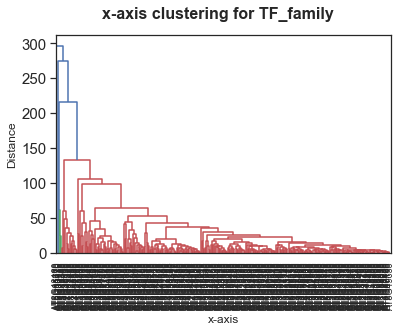

In [173]:


# rcParams['figure.figsize'] = 50, 9
# rcParams['axes.labelsize'] = "large"
# rcParams['font.size']= 20


get_clust_graph(rawx, 297, transpose=True,dataname="TF_family",xticksize=9)

In [174]:
give_cluster_assigns(rawx,297, transpose=False)

Cluster  1 : ( N = 1 ) AT3G50430
Cluster  2 : ( N = 1 ) AT3G09210
Cluster  3 : ( N = 1 ) AT5G15770
Cluster  4 : ( N = 1 ) AT1G16290
Cluster  5 : ( N = 1 ) AT3G01340
Cluster  6 : ( N = 1 ) AT2G20130
Cluster  7 : ( N = 1 ) AT2G47390
Cluster  8 : ( N = 1 ) AT4G36020
Cluster  9 : ( N = 1 ) AT2G46180
Cluster  10 : ( N = 1 ) AT3G44240
Cluster  11 : ( N = 1 ) AT1G11650
Cluster  12 : ( N = 1 ) AT1G08780
Cluster  13 : ( N = 1 ) AT1G27440
Cluster  14 : ( N = 1 ) AT3G17630
Cluster  15 : ( N = 1 ) AT1G03070
Cluster  16 : ( N = 1 ) AT3G12260
Cluster  17 : ( N = 1 ) AT5G47400
Cluster  18 : ( N = 1 ) AT4G07960
Cluster  19 : ( N = 1 ) AT1G28960
Cluster  20 : ( N = 1 ) AT1G10430
Cluster  21 : ( N = 1 ) AT4G30900
Cluster  22 : ( N = 1 ) AT1G01780
Cluster  23 : ( N = 1 ) AT1G03920
Cluster  24 : ( N = 1 ) AT3G20230
Cluster  25 : ( N = 1 ) AT3G60310
Cluster  26 : ( N = 1 ) AT3G01980
Cluster  27 : ( N = 1 ) AT5G45840
Cluster  28 : ( N = 1 ) AT2G22040
Cluster  29 : ( N = 1 ) AT4G01575
Cluster  30 : ( N = 1 )

##### If you're interested in cutting off the dendrogram to achieve a certain number of clusters, you can change the defined numclust variable as follows:


Not saving


g,"['(2)', '(276)', '(14)']"
b,"['(3)', 'AT5G01670', 'AT2G48160']"


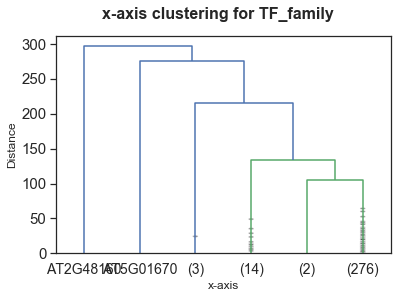

In [175]:
get_clust_graph(rawx, 6, transpose=True,dataname="TF_family",xticksize=14)

##### And we can use the give_cluster_assigns function to see exactly which genes are in these clusters.


In [176]:
give_cluster_assigns(rawx,6,transpose=False)

Cluster  1 : ( N = 3 ) AT3G50430, AT3G09210, AT5G15770
Cluster  2 : ( N = 14 ) AT1G03070, AT1G11650, AT1G16290, AT1G27440, AT2G20130, AT2G46180, AT3G01340, AT3G12260, AT3G17630, AT3G44240, AT4G36020, AT2G47390, AT5G47400, AT1G08780
Cluster  3 : ( N = 2 ) AT4G07960, AT1G28960
Cluster  4 : ( N = 276 ) AT1G01780, AT1G01910, AT1G02000, AT1G03457, AT1G03920, AT1G04700, AT1G06530, AT1G08340, AT1G09240, AT1G10430, AT1G11170, AT1G12450, AT1G13320, AT1G13970, AT1G15330, AT1G19540, AT1G24330, AT1G25420, AT1G26610, AT1G29230, AT1G31730, AT1G32370, AT1G34550, AT1G47270, AT1G48440, AT1G48900, AT1G49260, AT1G52730, AT1G54080, AT1G57760, AT1G58050, AT1G59830, AT1G61670, AT1G62710, AT1G64590, AT1G66540, AT1G68290, AT1G70790, AT1G71770, AT1G71820, AT1G74700, AT1G75030, AT1G78460, AT1G78920, AT1G79940, AT2G05170, AT2G07190, AT2G16860, AT2G17390, AT2G19790, AT2G20390, AT2G20790, AT2G20810, AT2G21540, AT2G22040, AT2G27600, AT2G28060, AT2G28390, AT2G28650, AT2G30100, AT2G31830, AT2G32170, AT2G33220, AT2G33

In [177]:
#use max distances between points in clusters
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
c_dist = pdist(rawx) # computing the distance
c_link = linkage(rawx,  metric='correlation', method='complete') # computing the linkage

In [178]:
rawx_index = groupby_promoter_counts_family_filtered.drop(['promoter_AGI','gene_type', 'cluster'],axis=1)
kmeans_raw = KMeans(n_clusters=5, random_state=0)

y_kmeans_raw = kmeans.fit_predict(rawx_index)
groupby_promoter_counts_family_filtered['raw_kmeans_cluster']= y_kmeans_raw
groupby_promoter_counts_family_filtered

,promoter_AGI,ABI3VP1,AP2EREBP,ARF,ARID,BBRBPC,BES1,BHLH,BZIP,BZR,...,NAC,ND,REM,SRS,TCP,TRIHELIX,WRKY,cluster,gene_type,raw_kmeans_cluster
0,AT1G01780,3,1,0,0,75,0,0,0,0,...,0,15,4,0,0,0,0,5,highVar,0
1,AT1G01910,1,8,0,0,0,0,0,0,0,...,0,0,0,0,0,8,0,0,housekeeping,4
2,AT1G02000,0,4,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,highVar,4
3,AT1G03070,13,49,0,0,4,0,0,0,0,...,0,0,9,0,0,0,0,2,highVar,4
4,AT1G03457,17,0,0,0,1,0,0,0,0,...,0,0,8,0,0,0,0,0,highVar,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,AT5G13410,2,23,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,randCont,4
293,AT5G56090,29,0,0,0,0,0,0,0,0,...,0,0,23,0,0,0,0,3,randCont,1
294,AT5G05170,1,1,1,0,5,0,0,0,0,...,0,0,1,0,0,0,0,0,randCont,4
295,AT3G18110,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,randCont,4


In [179]:
#how many in each cluster:
cluster_counts = groupby_promoter_counts_family_filtered.groupby('gene_type')['raw_kmeans_cluster'].value_counts()
cluster_counts

gene_type     raw_kmeans_cluster
highVar       4                     69
              1                     24
              0                      5
              2                      1
housekeeping  4                     81
              1                     11
              0                      3
              2                      2
              3                      1
randCont      4                     76
              1                     21
              2                      2
              0                      1
Name: raw_kmeans_cluster, dtype: int64

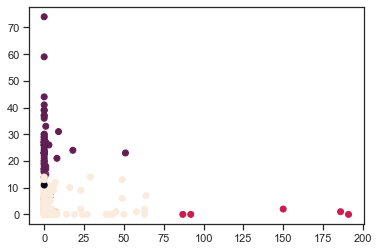

In [180]:
#plot
plt.scatter(groupby_promoter_counts_family_filtered.AP2EREBP, groupby_promoter_counts_family_filtered.ABI3VP1, c=y_kmeans_raw)
#find centre of each cluster
#centres = kmeans_raw.cluster_centers_
#add centres to the plot
#plt.scatter(centres[:, 0], centres[:, 33], c='black', s=200, alpha=0.5)

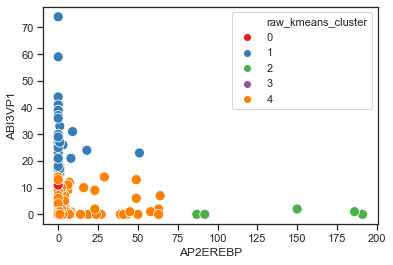

In [181]:
plot = sns.scatterplot(x='AP2EREBP', y='ABI3VP1', data=groupby_promoter_counts_family_filtered, hue='raw_kmeans_cluster', palette=sns.color_palette("Set1", 5),s=100)


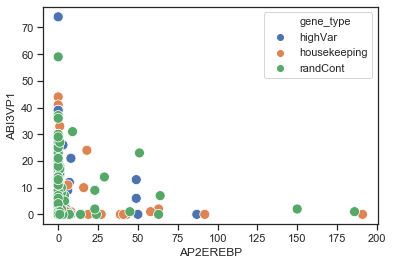

In [182]:
#colour by gene type
plot = sns.scatterplot(x='AP2EREBP', y='ABI3VP1', data=groupby_promoter_counts_family_filtered, hue='gene_type',s=100)


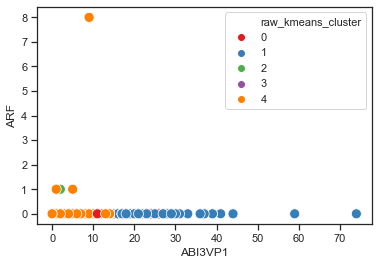

In [183]:
plot = sns.scatterplot(x='ABI3VP1', y='ARF', data=groupby_promoter_counts_family_filtered, hue='raw_kmeans_cluster',palette=sns.color_palette("Set1", 5),s=100)


# run PCA using 100 random_genes too

In [184]:
#standardise the families
PCA_rawx = StandardScaler().fit_transform(rawx)

In [185]:
#run PCA, letting the algorithm decide on number of components such that 95% of the variation is maintained
#make instance of the model
pca2 = PCA(.95)
#fit PCA to the data
rawx_principalComponents = pca2.fit_transform(PCA_rawx)
#make into dataframe
rawx_principalDf = pd.DataFrame(data= rawx_principalComponents)

In [186]:
#How much variance each component uses
pca2.explained_variance_ratio_

array([0.12798349, 0.08353872, 0.07006919, 0.06053564, 0.05994472,
       0.05797892, 0.04094398, 0.03664229, 0.03293928, 0.03245883,
       0.0309154 , 0.03060705, 0.03056311, 0.03040823, 0.03040601,
       0.03004212, 0.02972263, 0.02906195, 0.02826155, 0.0275209 ,
       0.02222526, 0.01939998, 0.01504097])

In [187]:
rawx_principalDf

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,0.043934,3.343776,-3.863063,-0.079095,2.635256,-2.596909,1.362762,0.658028,0.689114,0.582080,...,0.006616,-0.001405,0.076590,-0.840030,0.238532,-1.153771,0.178757,-0.087521,-0.389757,-1.319567
1,3.511223,-1.727531,0.669138,0.182264,-1.102330,-0.011539,3.227033,1.839829,-1.189599,0.357993,...,0.009919,-0.003584,-0.552639,0.783414,0.523299,-2.696237,0.198710,4.441829,4.232843,0.341533
2,0.113420,-0.844214,0.313849,-0.182863,0.201982,-0.602080,-1.363701,0.264360,-0.208404,-0.510575,...,-0.021295,0.004984,-0.320794,0.786981,0.820542,-0.925228,-0.266927,0.991198,-1.932012,-0.079230
3,3.610051,0.968609,-0.495196,0.185496,-0.781148,1.047960,-0.698284,-0.899509,0.238529,-0.262941,...,0.013782,-0.006970,0.153905,-0.248619,-0.839479,0.642935,-0.500998,-0.047602,1.000135,-1.544487
4,-0.781838,-0.124577,-0.025249,-0.027487,-0.519933,0.450394,-0.007532,-0.071446,-0.191937,-0.126919,...,-0.001927,0.001913,-0.142138,0.046027,-0.194407,0.035002,-0.100822,-0.136560,-0.016612,0.235071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,2.322942,-1.390161,0.646380,-0.018196,-0.731117,0.072821,-0.636955,-2.557121,2.717388,-3.893087,...,0.596892,-0.496059,-4.598169,-1.901425,6.126207,-2.180868,2.360918,1.339040,-0.253880,0.076106
293,-1.156673,1.127960,-0.282163,0.113303,-1.128865,1.505324,-0.258547,0.007304,-0.597541,-0.206944,...,-0.005546,0.001885,-0.305389,-0.006659,-0.211745,0.415899,-0.111284,0.031208,0.206469,0.923495
294,0.611160,-0.817274,0.271463,-0.796194,1.058820,0.405986,0.006245,-0.437255,0.131520,-0.158958,...,0.002512,0.001124,0.029515,0.048759,-0.251839,-0.116293,-0.163102,-0.373601,0.005865,-0.324753
295,0.211227,-0.723621,0.791389,-0.119408,0.168590,-0.675489,0.231941,-0.425061,-0.132960,-0.215490,...,0.001022,0.000966,0.030887,0.135639,-0.304072,-0.215489,-0.196441,-0.361883,-0.079480,0.171323


In [188]:
finalrawx_principalDf = pd.concat([rawx_principalDf, groupby_promoter_counts_family_filtered[['promoter_AGI', 'gene_type','raw_kmeans_cluster']]], axis=1)
#finalDF_variable_promoters = finalDF_variable_promoters.set_index('promoter_AGI')
finalrawx_principalDf

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,promoter_AGI,gene_type,raw_kmeans_cluster
0,0.043934,3.343776,-3.863063,-0.079095,2.635256,-2.596909,1.362762,0.658028,0.689114,0.582080,...,-0.840030,0.238532,-1.153771,0.178757,-0.087521,-0.389757,-1.319567,AT1G01780,highVar,0
1,3.511223,-1.727531,0.669138,0.182264,-1.102330,-0.011539,3.227033,1.839829,-1.189599,0.357993,...,0.783414,0.523299,-2.696237,0.198710,4.441829,4.232843,0.341533,AT1G01910,housekeeping,4
2,0.113420,-0.844214,0.313849,-0.182863,0.201982,-0.602080,-1.363701,0.264360,-0.208404,-0.510575,...,0.786981,0.820542,-0.925228,-0.266927,0.991198,-1.932012,-0.079230,AT1G02000,highVar,4
3,3.610051,0.968609,-0.495196,0.185496,-0.781148,1.047960,-0.698284,-0.899509,0.238529,-0.262941,...,-0.248619,-0.839479,0.642935,-0.500998,-0.047602,1.000135,-1.544487,AT1G03070,highVar,4
4,-0.781838,-0.124577,-0.025249,-0.027487,-0.519933,0.450394,-0.007532,-0.071446,-0.191937,-0.126919,...,0.046027,-0.194407,0.035002,-0.100822,-0.136560,-0.016612,0.235071,AT1G03457,highVar,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,2.322942,-1.390161,0.646380,-0.018196,-0.731117,0.072821,-0.636955,-2.557121,2.717388,-3.893087,...,-1.901425,6.126207,-2.180868,2.360918,1.339040,-0.253880,0.076106,AT5G13410,randCont,4
293,-1.156673,1.127960,-0.282163,0.113303,-1.128865,1.505324,-0.258547,0.007304,-0.597541,-0.206944,...,-0.006659,-0.211745,0.415899,-0.111284,0.031208,0.206469,0.923495,AT5G56090,randCont,1
294,0.611160,-0.817274,0.271463,-0.796194,1.058820,0.405986,0.006245,-0.437255,0.131520,-0.158958,...,0.048759,-0.251839,-0.116293,-0.163102,-0.373601,0.005865,-0.324753,AT5G05170,randCont,4
295,0.211227,-0.723621,0.791389,-0.119408,0.168590,-0.675489,0.231941,-0.425061,-0.132960,-0.215490,...,0.135639,-0.304072,-0.215489,-0.196441,-0.361883,-0.079480,0.171323,AT3G18110,randCont,4


Not saving


g,"['AT3G50430', 'AT5G15770']"
r,"['AT2G20390', 'AT5G01670']"
c,"['AT3G17130', 'AT1G59910', 'AT1G05810']"
b,"['AT2G20810', 'AT5G13410', 'AT2G39840', 'AT2G48160', 'AT5G15600']"
m,"['AT2G42320', 'AT3G20410', 'AT3G44240', 'AT5G47400', 'AT2G47710', 'AT3G13445', 'AT4G18640', 'AT3G01980', 'AT1G12450', 'AT4G27960', 'AT3G02555', 'AT5G03690', 'AT1G11650', 'AT5G55840', 'AT5G60490', 'AT2G02100', 'AT5G16540', 'AT1G02000', 'AT2G46180', 'AT1G08780', 'AT4G17050', 'AT4G36020', 'AT5G23270', 'AT2G22040', 'AT4G01575', 'AT4G07960', 'AT1G28960', 'AT1G01780', 'AT5G45840', 'AT1G10430', 'AT4G30900', 'AT1G03920', 'AT1G04700', 'AT3G20230', 'AT1G29040', 'AT4G34670', 'AT5G03170', 'AT4G38660', 'AT3G60310', 'AT3G12260', 'AT3G09210', 'AT2G20130', 'AT5G64050', 'AT3G17630', 'AT2G47390', 'AT3G10380', 'AT1G16290', 'AT1G03070', 'AT1G27440', 'AT4G26410', 'AT3G01340', 'AT5G07950', 'AT1G10320', 'AT2G41080', 'AT2G46210', 'AT1G78920', 'AT2G33590', 'AT1G52730', 'AT5G08290', 'AT2G17390', 'AT1G01910', 'AT1G49260', 'AT5G57785', 'AT1G57760', 'AT1G10490', 'AT1G54080', 'AT1G13320', 'AT5G61360', 'AT1G62730', 'AT2G28060', 'AT3G57610', 'AT3G02600', 'AT3G61160', 'AT3G59280', 'AT5G17420', 'AT3G61460', 'AT5G20700', 'AT5G11670', 'AT5G06600', 'AT2G27600', 'AT1G08340', 'AT3G60570', 'AT1G34550', 'AT5G45940', 'AT3G51610', 'AT2G31370', 'AT3G25160', 'AT5G24090', 'AT1G64400', 'AT1G11170', 'AT1G08600', 'AT1G10070', 'AT5G56090', 'AT3G10960', 'AT3G46600', 'AT3G03790', 'AT1G68410', 'AT1G74700', 'AT3G01270', 'AT5G46750', 'AT1G13970', 'AT1G68290', 'AT2G28390', 'AT5G58710', 'AT5G54780', 'AT5G46210', 'AT4G05330', 'AT1G08940', 'AT1G79940', 'AT3G51300', 'AT5G58230', 'AT2G41960', 'AT5G51770', 'AT3G03070', 'AT3G45750', 'AT5G16450', 'AT5G16950', 'AT4G04500', 'AT3G55480', 'AT4G27630', 'AT1G24330', 'AT5G24710', 'AT2G33220', 'AT5G54690', 'AT1G53520', 'AT5G64813', 'AT5G67590', 'AT3G09760', 'AT3G19870', 'AT3G44070', 'AT3G13320', 'AT4G32560', 'AT5G50170', 'AT2G38950', 'AT3G18810', 'AT1G80630', 'AT1G32370', 'AT3G56460', 'AT1G25420', 'AT5G05170', 'AT1G75030', 'AT1G48440', 'AT3G10020', 'AT1G62710', 'AT5G12240', 'AT3G18110', 'AT1G71770', 'AT1G06110', 'AT3G57890', 'AT4G33650', 'AT3G57390', 'AT1G28580', 'AT3G09880', 'AT5G41685', 'AT1G66540', 'AT3G48510', 'AT3G19970', 'AT2G30360', 'AT1G26610', 'AT5G46080', 'AT3G23170', 'AT3G19090', 'AT5G56160', 'AT1G78460', 'AT2G21540', 'AT1G03457', 'AT2G38465', 'AT4G18230', 'AT3G52380', 'AT3G52730', 'AT1G61670', 'AT1G71820', 'AT2G44790', 'AT5G22860', 'AT1G47270', 'AT1G78460', 'AT3G09880', 'AT4G26640', 'AT5G67210', 'AT5G18280', 'AT2G05170', 'AT3G60480', 'AT5G56270', 'AT1G49850', 'AT2G30170', 'AT1G75850', 'AT3G01150', 'AT4G21760', 'AT4G18425', 'AT5G51210', 'AT1G58050', 'AT5G17890', 'AT4G14160', 'AT1G10760', 'AT5G46020', 'AT1G58050', 'AT3G16350', 'AT4G22490', 'AT5G09570', 'AT5G46630', 'AT3G21510', 'AT4G24550', 'AT1G09240', 'AT4G33380', 'AT3G58460', 'AT3G25900', 'AT2G20790', 'AT1G75440', 'AT3G32260', 'AT3G47550', 'AT2G37160', 'AT2G20840', 'AT1G65490', 'AT1G67970', 'AT3G11850', 'AT3G59010', 'AT4G37480', 'AT5G12370', 'AT3G17880', 'AT2G19790', 'AT2G35320', 'AT5G56750', 'AT4G19960', 'AT1G70790', 'AT5G62650', 'AT2G30100', 'AT1G51450', 'AT3G09220', 'AT4G22960', 'AT3G18480', 'AT2G18840', 'AT5G21100', 'AT4G13730', 'AT4G17690', 'AT2G39210', 'AT2G36320', 'AT1G19540', 'AT3G24820', 'AT5G14710', 'AT2G38080', 'AT5G16100', 'AT5G10780', 'AT4G39220', 'AT2G02230', 'AT2G45310', 'AT3G42640', 'AT5G15630', 'AT5G13470', 'AT3G11240', 'AT3G21865', 'AT4G34270', 'AT5G17400', 'AT3G54590', 'AT5G45380', 'AT4G31020', 'AT2G31830', 'AT5G20410', 'AT1G48900', 'AT3G43960', 'AT1G15330', 'AT5G42070', 'AT4G30340', 'AT1G08610', 'AT1G64590', 'AT2G40620', 'AT1G06530', 'AT5G66250', 'AT2G40290', 'AT2G16700', 'AT2G07190', 'AT5G49630', 'AT5G10430', 'AT3G10330', 'AT3G16090', 'AT3G52760', 'AT1G59830', 'AT1G34020', 'AT2G16860', 'AT1G55260', 'AT1G31730', 'AT2G32170', 'AT1G29230', 'AT2G28650', 'AT4G27120', 'AT5G13450', 'AT5G51300', 'AT4G21090', 'AT5G01610']"


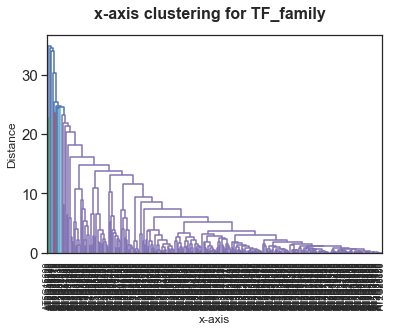

In [189]:
### hierarchical clustering of PCA including 100 random genes
#drop columns and change index
droppedfinalrawx_principalDf = finalrawx_principalDf.drop(['gene_type', 'raw_kmeans_cluster'],axis=1)

droppedfinalrawx_principalDf = droppedfinalrawx_principalDf.set_index('promoter_AGI')

get_clust_graph(droppedfinalrawx_principalDf, 297, transpose=True,dataname="TF_family",xticksize=9)

In [190]:
give_cluster_assigns(droppedfinalrawx_principalDf,6, transpose=False)

Cluster  1 : ( N = 2 ) AT3G50430, AT5G15770
Cluster  2 : ( N = 2 ) AT2G20390, AT5G01670
Cluster  3 : ( N = 290 ) AT1G01780, AT1G01910, AT1G02000, AT1G03070, AT1G03457, AT1G03920, AT1G04700, AT1G06530, AT1G08340, AT1G09240, AT1G10430, AT1G11170, AT1G11650, AT1G12450, AT1G13320, AT1G13970, AT1G15330, AT1G16290, AT1G19540, AT1G24330, AT1G25420, AT1G26610, AT1G27440, AT1G29230, AT1G31730, AT1G32370, AT1G34550, AT1G47270, AT1G48440, AT1G48900, AT1G49260, AT1G52730, AT1G54080, AT1G57760, AT1G58050, AT1G59830, AT1G61670, AT1G62710, AT1G64590, AT1G66540, AT1G68290, AT1G70790, AT1G71770, AT1G71820, AT1G74700, AT1G75030, AT1G78460, AT1G78920, AT1G79940, AT2G05170, AT2G07190, AT2G16860, AT2G17390, AT2G19790, AT2G20130, AT2G20790, AT2G20810, AT2G21540, AT2G22040, AT2G27600, AT2G28060, AT2G28390, AT2G28650, AT2G30100, AT2G31830, AT2G32170, AT2G33220, AT2G33590, AT2G35320, AT2G37160, AT2G38080, AT2G38465, AT2G38950, AT2G40620, AT2G41960, AT2G44790, AT2G45310, AT2G46180, AT2G46210, AT3G01150, AT3G012

## decide how many clusters for kmeans


In [191]:

#linkage matrix
rawz = shc.linkage(droppedfinalrawx_principalDf, method='ward')

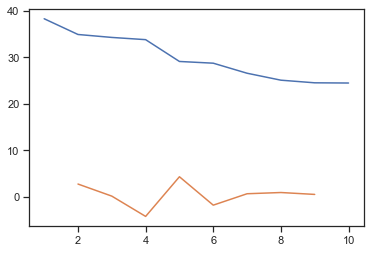

clusters: 5


In [192]:
#try elbow method
last = rawz[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print("clusters:", k)

In [193]:
# 6 clusters

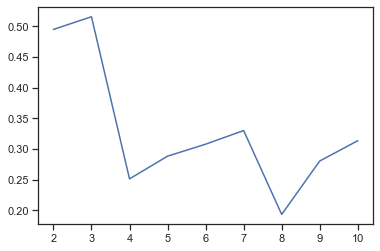

In [194]:
#silhouette method - The silhouette value measures how similar a point is to its own cluster (cohesion) compared to other clusters (separation).
from sklearn.metrics import silhouette_score
sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(droppedfinalrawx_principalDf)
  labels = kmeans.labels_
  sil.append(silhouette_score(droppedfinalrawx_principalDf, labels, metric = 'euclidean'))
#plot silhouette_score vs k
plot = sns.lineplot(x=list(range(2, 11,1)), y=sil)

### look for peak - 6 clusters

## do kmeans clustering on PCA inluding 100 random genes

In [264]:
PCA_kmeans_including_rand = KMeans(n_clusters=2, random_state=0)
y_PCA_kmeans_including_rand = PCA_kmeans_including_rand.fit_predict(droppedfinalrawx_principalDf)
finalrawx_principalDf['Kmeans_PCA_cluster']= y_PCA_kmeans_including_rand

In [265]:
finalrawx_principalDf

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,promoter_AGI,gene_type,raw_kmeans_cluster,PCA_cluster,KmeansPCA_cluster,Kmeans_PCA_cluster
0,0.043934,3.343776,-3.863063,-0.079095,2.635256,-2.596909,1.362762,0.658028,0.689114,0.582080,...,0.178757,-0.087521,-0.389757,-1.319567,AT1G01780,highVar,0,1,1,1
1,3.511223,-1.727531,0.669138,0.182264,-1.102330,-0.011539,3.227033,1.839829,-1.189599,0.357993,...,0.198710,4.441829,4.232843,0.341533,AT1G01910,housekeeping,4,0,0,0
2,0.113420,-0.844214,0.313849,-0.182863,0.201982,-0.602080,-1.363701,0.264360,-0.208404,-0.510575,...,-0.266927,0.991198,-1.932012,-0.079230,AT1G02000,highVar,4,1,1,1
3,3.610051,0.968609,-0.495196,0.185496,-0.781148,1.047960,-0.698284,-0.899509,0.238529,-0.262941,...,-0.500998,-0.047602,1.000135,-1.544487,AT1G03070,highVar,4,0,0,0
4,-0.781838,-0.124577,-0.025249,-0.027487,-0.519933,0.450394,-0.007532,-0.071446,-0.191937,-0.126919,...,-0.100822,-0.136560,-0.016612,0.235071,AT1G03457,highVar,4,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,2.322942,-1.390161,0.646380,-0.018196,-0.731117,0.072821,-0.636955,-2.557121,2.717388,-3.893087,...,2.360918,1.339040,-0.253880,0.076106,AT5G13410,randCont,4,1,1,1
293,-1.156673,1.127960,-0.282163,0.113303,-1.128865,1.505324,-0.258547,0.007304,-0.597541,-0.206944,...,-0.111284,0.031208,0.206469,0.923495,AT5G56090,randCont,1,1,1,1
294,0.611160,-0.817274,0.271463,-0.796194,1.058820,0.405986,0.006245,-0.437255,0.131520,-0.158958,...,-0.163102,-0.373601,0.005865,-0.324753,AT5G05170,randCont,4,1,1,1
295,0.211227,-0.723621,0.791389,-0.119408,0.168590,-0.675489,0.231941,-0.425061,-0.132960,-0.215490,...,-0.196441,-0.361883,-0.079480,0.171323,AT3G18110,randCont,4,1,1,1


In [284]:
## run raw k means on PCA data including 100 random promoters
finalrawx_principalDf.dtypes


0                     float64
1                     float64
2                     float64
3                     float64
4                     float64
5                     float64
6                     float64
7                     float64
8                     float64
9                     float64
10                    float64
11                    float64
12                    float64
13                    float64
14                    float64
15                    float64
16                    float64
17                    float64
18                    float64
19                    float64
20                    float64
21                    float64
22                    float64
promoter_AGI           object
gene_type              object
raw_kmeans_cluster      int32
PCA_cluster             int32
KmeansPCA_cluster       int32
Kmeans_PCA_cluster      int32
dtype: object

In [285]:
finalrawx_principalDf.PCA_cluster.unique()


array([1, 0])

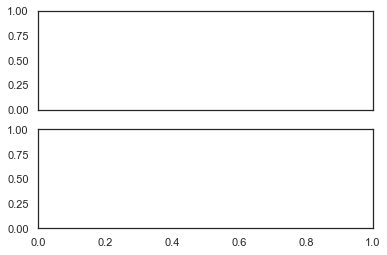

In [286]:
#create subplots
fig, ax = plt.subplots(2, sharex='col', sharey='row')

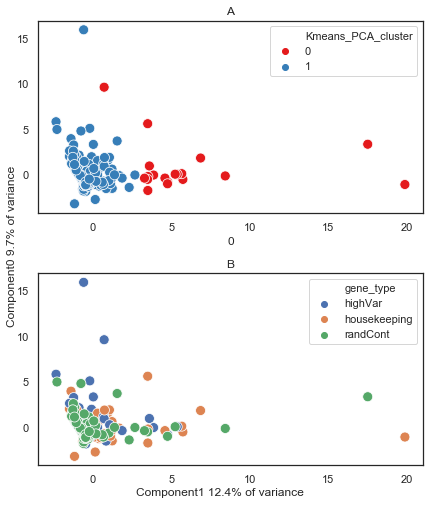

In [323]:
##plot first 2 PCA components using 100 random genes too, coloured by cluster
sns.set(color_codes=True, font_scale=1)
sns.set_style("white")
# Create a figure instance, and the two subplots
fig = plt.figure(figsize=(6,7))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
#add custom palette size as sns doesnt like having numeric values for hue palette=sns.color_palette("Set1", 6)

plot = sns.scatterplot(x=0, y=1, hue='Kmeans_PCA_cluster', data=finalrawx_principalDf,s=100, palette=sns.color_palette("Set1", 2), ax=ax1)
plot2 = sns.scatterplot(x=0, y=1, hue='gene_type', data=finalrawx_principalDf, s=100, ax=ax2);
#add graph titles
ax1.set(ylabel='', title='A')
ax2.set(xlabel='', ylabel='', title='B')
fig.tight_layout()

#Add axes labels
fig.text(0.5, 0.01, 'Component1 12.4% of variance', ha='center', va='center')
fig.text(0.02, 0.5, 'Component0 9.7% of variance', ha='center', va='center', rotation='vertical')

fig.savefig("../../data/plots/TF_diversity/responsiveTF_diversity_kmeans.pdf")

In [301]:
## how many in each cluster
cluster_counts_PCA_incl_rand_genes = finalrawx_principalDf.groupby('gene_type')['PCA_cluster'].value_counts()
cluster_counts_PCA_incl_rand_genes

gene_type     PCA_cluster
highVar       1              94
              0               5
housekeeping  1              90
              0               8
randCont      1              94
              0               6
Name: PCA_cluster, dtype: int64

## clustering of groupby_promoter_counts_family, using sklearn.mixture.BayesianGaussianMixture


In [204]:
merged

,promoter_AGI,S_unique_TF_count,Shannon_diversity_TF,Shannon_diversity_TF_family,gene,gene_type,raw_TF_count,TF_family_count
0,AT1G01050,4,1.842371,1.842371,AT1G01050,randCont,7,4
1,AT1G01780,19,3.147482,1.718292,AT1G01780,highVar,119,7
2,AT1G01910,16,3.763856,2.323856,AT1G01910,housekeeping,25,7
3,AT1G02000,7,2.750000,2.000000,AT1G02000,highVar,8,5
4,AT1G03070,43,4.931641,2.403916,AT1G03070,highVar,101,9
...,...,...,...,...,...,...,...,...
394,AT5G65360,5,2.155639,1.561278,AT5G65360,randCont,8,3
395,AT5G65470,3,1.251629,1.251629,AT5G65470,randCont,6,3
396,AT5G66250,1,-0.000000,-0.000000,AT5G66250,randCont,1,1
397,AT5G67210,9,2.928213,2.690469,AT5G67210,highVar,20,7


In [205]:
x

array([[-0.54255807, -0.21043974, -0.08803827, ...,  0.        ,
        -0.22192004,  0.        ],
       [-0.73479537,  0.16160693, -0.08803827, ...,  0.        ,
         7.55021293,  0.        ],
       [-0.83091402, -0.05099117, -0.08803827, ...,  0.        ,
        -0.22192004,  0.        ],
       ...,
       [ 0.8992217 , -0.21043974, -0.08803827, ...,  0.        ,
        -0.22192004,  0.        ],
       [-0.83091402, -0.26358926, -0.08803827, ...,  0.        ,
        -0.22192004,  0.        ],
       [-0.35032077, -0.26358926, -0.08803827, ...,  0.        ,
        -0.22192004,  0.        ]])